## Step 1: Importing the packages

In [2]:
#library which integrates code with operating system
import os 

# used to generate random vector of data/noise as input for the generator
import random 

# helps us write user-frindly code, especially when dealing with varaibles within functions
import argparse 

#main PyTorch framework and libraries we need to use
import torch 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np #used for most of our mathematical oprations

#packages for creating our plots and animations
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

## Step 2: Getting data and defining hyperparameters

In [4]:
# Root directory for dataset
dataroot = #enter file path to target folder here

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8 #128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3 (use 1 for black & white)
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

## Step 3: Loading and plotting our intial data

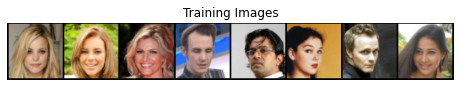

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,# the folder where the data is located
                           #reshaping the data in the form we desire
                           transform=transforms.Compose([
                               transforms.Resize(image_size),#resizing
                               transforms.CenterCrop(image_size), #cropping and centering
                               transforms.ToTensor(), #tranforming image data to tensors
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalising the data
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True, #shuffing images so the  genrator doesn't overfit on the sequence
                                         num_workers=workers)

# Decide which device we want to run on. Basically telling the model to run on the GPU if its available.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some random training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Step 4: Initialising our weights

In [4]:
# creating a function which will intialise our weights
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1.0:
        #initalisation of weights based on Normal distro
        nn.init.normal_(m.weight.data, 0.0, 0.02) #mean 0, std.dev 0.02
    elif classname.find('BatchNorm') != -1.0: 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

## Step 4: Defining the Generator class & creating the Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu): #defininng the initial function
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential( #squencing the main as a sequential neural network
            # input is Z, going into a convolution
            # ConvTranspose2d applies a 2D transposed convolution operator over an input image composed of several input planes.
            #https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
            # we can change the keral size if we wish(third parameter)
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False), 
            
            #Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) 
            #as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            #https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
            #notice the input has to match the second arguement of the above function (the output channel)
            nn.BatchNorm2d(ngf * 8),
            
            ##using the reLU as the activation function
            nn.ReLU(True),
            
            #repeating the above steps three more times for three different sizes
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            #this leaves us with our desired output size
            # state size. (nc) x 64 x 64
        )

    #creating a function for the forward propagation
    def forward(self, input):
        return self.main(input)

In [6]:
#After defining the Generator in the previous step, we have to now create the Generator object

#here we are asking our gpu (or cpu) to create our Generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Step 4: Defining the Discriminator class & creating the Discriminator

In [7]:
# The Discriminator is essentially the revese of the Generator, so the architecture is very similar
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            #Conv2d applies a 2D convolution over an input signal composed of several input planes.
            #https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            
            # Leaky ReLU has beenfis over regual ReLU for the discriminator (you can still use regular ReLU)
            nn.LeakyReLU(0.2, inplace=True),
            
            # Repeating the  steps, like the Generator, except this time with descneding sizes
            # This is because are taking the ouput of the Generator as an input, and shrinking it down to a data value
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            #using a sigmoid function to determine whether the prediction is for real or fake
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Step 5: Creating a binary cross-entropy loss function

In [9]:
# info on binary cross-entropy:
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
# torch.randn returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)[0,1)
# https://pytorch.org/docs/stable/generated/torch.rand.html
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both Generator and Discriminator
# Notes on Adam Optimisers:
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.
# Notes on TORCH.OPTIM:
# https://pytorch.org/docs/stable/optim.html
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################

        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))

        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, 1), real_label, device=device, dtype=torch.float).view(-1)

        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with Generator
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)

        # Calculate Discriminator's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Update Discriminator
        optimizerD.step()

        ############################

        # (2) Update Generator network: maximize log(D(G(z)))

        ###########################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated Discriminator, perform another forward pass of all-fake batch through Discriminator
        output = netD(fake).view(-1)

        # Calculate Generator's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for Generator
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update Generator
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the Generator is doing by saving Generator's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

           # for item in fake: 
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

               # img_list.append(vutils.make_grid(item,normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/4704]	Loss_D: 1.6961	Loss_G: 6.1168	D(x): 0.3863	D(G(z)): 0.4292 / 0.0029
[0/100][50/4704]	Loss_D: 0.0716	Loss_G: 16.1219	D(x): 0.9446	D(G(z)): 0.0001 / 0.0000
[0/100][100/4704]	Loss_D: 0.2261	Loss_G: 18.0234	D(x): 0.9996	D(G(z)): 0.1717 / 0.0000
[0/100][150/4704]	Loss_D: 0.0037	Loss_G: 7.5666	D(x): 1.0000	D(G(z)): 0.0036 / 0.0039
[0/100][200/4704]	Loss_D: 0.6169	Loss_G: 21.9659	D(x): 0.7142	D(G(z)): 0.0000 / 0.0000
[0/100][250/4704]	Loss_D: 0.3515	Loss_G: 12.4747	D(x): 0.8432	D(G(z)): 0.0000 / 0.0000
[0/100][300/4704]	Loss_D: 0.1287	Loss_G: 19.6994	D(x): 0.8962	D(G(z)): 0.0000 / 0.0000
[0/100][350/4704]	Loss_D: 1.9062	Loss_G: 10.4208	D(x): 0.8605	D(G(z)): 0.7033 / 0.0001
[0/100][400/4704]	Loss_D: 0.3782	Loss_G: 11.3199	D(x): 0.9973	D(G(z)): 0.2758 / 0.0000
[0/100][450/4704]	Loss_D: 0.6094	Loss_G: 3.3641	D(x): 0.8923	D(G(z)): 0.1937 / 0.0889
[0/100][500/4704]	Loss_D: 0.3838	Loss_G: 5.7871	D(x): 0.8132	D(G(z)): 0.1061 / 0.0094
[0/100][550/4704]	Loss_D

[1/100][0/4704]	Loss_D: 0.3660	Loss_G: 3.6516	D(x): 0.8130	D(G(z)): 0.1122 / 0.0427
[1/100][50/4704]	Loss_D: 1.0066	Loss_G: 1.3092	D(x): 0.4611	D(G(z)): 0.1179 / 0.2787
[1/100][100/4704]	Loss_D: 0.6918	Loss_G: 4.7084	D(x): 0.8893	D(G(z)): 0.3796 / 0.0110
[1/100][150/4704]	Loss_D: 0.4387	Loss_G: 5.0613	D(x): 0.9923	D(G(z)): 0.3049 / 0.0081
[1/100][200/4704]	Loss_D: 0.1492	Loss_G: 4.4762	D(x): 0.9795	D(G(z)): 0.1048 / 0.0171
[1/100][250/4704]	Loss_D: 0.2245	Loss_G: 4.5412	D(x): 0.8565	D(G(z)): 0.0541 / 0.0127
[1/100][300/4704]	Loss_D: 0.1200	Loss_G: 4.5325	D(x): 0.9435	D(G(z)): 0.0525 / 0.0254
[1/100][350/4704]	Loss_D: 1.6735	Loss_G: 1.9550	D(x): 0.2306	D(G(z)): 0.0116 / 0.2219
[1/100][400/4704]	Loss_D: 0.0910	Loss_G: 3.9747	D(x): 0.9540	D(G(z)): 0.0411 / 0.0252
[1/100][450/4704]	Loss_D: 0.1754	Loss_G: 5.1993	D(x): 0.8746	D(G(z)): 0.0326 / 0.0107
[1/100][500/4704]	Loss_D: 0.3589	Loss_G: 3.3995	D(x): 0.7464	D(G(z)): 0.0322 / 0.0431
[1/100][550/4704]	Loss_D: 0.7070	Loss_G: 4.8378	D(x): 0.8

[2/100][0/4704]	Loss_D: 1.0410	Loss_G: 1.9132	D(x): 0.6596	D(G(z)): 0.3596 / 0.1598
[2/100][50/4704]	Loss_D: 0.5070	Loss_G: 4.0740	D(x): 0.8962	D(G(z)): 0.2900 / 0.0261
[2/100][100/4704]	Loss_D: 1.1263	Loss_G: 2.9149	D(x): 0.5444	D(G(z)): 0.2751 / 0.0694
[2/100][150/4704]	Loss_D: 0.6039	Loss_G: 2.8225	D(x): 0.7528	D(G(z)): 0.2308 / 0.0635
[2/100][200/4704]	Loss_D: 4.2266	Loss_G: 1.0528	D(x): 0.0348	D(G(z)): 0.0788 / 0.3722
[2/100][250/4704]	Loss_D: 0.6535	Loss_G: 2.9552	D(x): 0.6653	D(G(z)): 0.1484 / 0.0596
[2/100][300/4704]	Loss_D: 0.6749	Loss_G: 1.6444	D(x): 0.7361	D(G(z)): 0.2932 / 0.1979
[2/100][350/4704]	Loss_D: 1.1879	Loss_G: 3.1758	D(x): 0.7021	D(G(z)): 0.4445 / 0.0594
[2/100][400/4704]	Loss_D: 0.3155	Loss_G: 3.4255	D(x): 0.8209	D(G(z)): 0.0744 / 0.0471
[2/100][450/4704]	Loss_D: 0.5855	Loss_G: 3.5978	D(x): 0.9468	D(G(z)): 0.3540 / 0.0472
[2/100][500/4704]	Loss_D: 0.6437	Loss_G: 2.4397	D(x): 0.6434	D(G(z)): 0.1195 / 0.1093
[2/100][550/4704]	Loss_D: 0.8564	Loss_G: 2.2206	D(x): 0.5

[3/100][0/4704]	Loss_D: 1.2396	Loss_G: 4.5623	D(x): 0.9991	D(G(z)): 0.6446 / 0.0140
[3/100][50/4704]	Loss_D: 0.4764	Loss_G: 3.1171	D(x): 0.8621	D(G(z)): 0.2423 / 0.0496
[3/100][100/4704]	Loss_D: 0.5447	Loss_G: 3.9919	D(x): 0.9891	D(G(z)): 0.3319 / 0.0225
[3/100][150/4704]	Loss_D: 0.2712	Loss_G: 2.6211	D(x): 0.8902	D(G(z)): 0.1395 / 0.0859
[3/100][200/4704]	Loss_D: 0.3478	Loss_G: 2.5866	D(x): 0.8552	D(G(z)): 0.1452 / 0.0847
[3/100][250/4704]	Loss_D: 1.2632	Loss_G: 1.5450	D(x): 0.3900	D(G(z)): 0.1313 / 0.2610
[3/100][300/4704]	Loss_D: 0.5696	Loss_G: 3.4528	D(x): 0.8695	D(G(z)): 0.3023 / 0.0365
[3/100][350/4704]	Loss_D: 0.5553	Loss_G: 3.1545	D(x): 0.7954	D(G(z)): 0.2309 / 0.0574
[3/100][400/4704]	Loss_D: 3.5719	Loss_G: 2.8132	D(x): 0.8972	D(G(z)): 0.9569 / 0.0977
[3/100][450/4704]	Loss_D: 0.4786	Loss_G: 3.1323	D(x): 0.7264	D(G(z)): 0.1109 / 0.0625
[3/100][500/4704]	Loss_D: 0.3391	Loss_G: 3.7233	D(x): 0.9699	D(G(z)): 0.2428 / 0.0290
[3/100][550/4704]	Loss_D: 0.2795	Loss_G: 1.8913	D(x): 0.8

[4/100][0/4704]	Loss_D: 0.2745	Loss_G: 2.4132	D(x): 0.9885	D(G(z)): 0.2137 / 0.1085
[4/100][50/4704]	Loss_D: 0.5231	Loss_G: 3.1624	D(x): 0.8197	D(G(z)): 0.2302 / 0.0538
[4/100][100/4704]	Loss_D: 1.1867	Loss_G: 3.1562	D(x): 0.7668	D(G(z)): 0.5314 / 0.0502
[4/100][150/4704]	Loss_D: 0.2830	Loss_G: 3.3807	D(x): 0.8453	D(G(z)): 0.0918 / 0.0410
[4/100][200/4704]	Loss_D: 0.3543	Loss_G: 3.6629	D(x): 0.7310	D(G(z)): 0.0340 / 0.0308
[4/100][250/4704]	Loss_D: 0.2859	Loss_G: 3.2287	D(x): 0.9458	D(G(z)): 0.1979 / 0.0447
[4/100][300/4704]	Loss_D: 0.4071	Loss_G: 2.6423	D(x): 0.9186	D(G(z)): 0.2585 / 0.0790
[4/100][350/4704]	Loss_D: 0.2243	Loss_G: 3.3450	D(x): 0.9131	D(G(z)): 0.1139 / 0.0454
[4/100][400/4704]	Loss_D: 0.4006	Loss_G: 3.9394	D(x): 0.9171	D(G(z)): 0.2524 / 0.0237
[4/100][450/4704]	Loss_D: 0.8935	Loss_G: 5.5531	D(x): 0.9356	D(G(z)): 0.5150 / 0.0047
[4/100][500/4704]	Loss_D: 0.9700	Loss_G: 3.7096	D(x): 0.8486	D(G(z)): 0.4410 / 0.0261
[4/100][550/4704]	Loss_D: 0.3764	Loss_G: 3.2655	D(x): 0.8

[5/100][0/4704]	Loss_D: 0.1736	Loss_G: 4.4675	D(x): 0.9802	D(G(z)): 0.1376 / 0.0140
[5/100][50/4704]	Loss_D: 0.2360	Loss_G: 4.3304	D(x): 0.9366	D(G(z)): 0.1461 / 0.0155
[5/100][100/4704]	Loss_D: 0.4698	Loss_G: 3.1767	D(x): 0.7903	D(G(z)): 0.1668 / 0.0470
[5/100][150/4704]	Loss_D: 0.4021	Loss_G: 3.7020	D(x): 0.9884	D(G(z)): 0.2895 / 0.0293
[5/100][200/4704]	Loss_D: 2.1807	Loss_G: 4.3883	D(x): 0.9893	D(G(z)): 0.8221 / 0.0146
[5/100][250/4704]	Loss_D: 0.1503	Loss_G: 3.9917	D(x): 0.9032	D(G(z)): 0.0402 / 0.0237
[5/100][300/4704]	Loss_D: 0.6046	Loss_G: 2.9764	D(x): 0.6793	D(G(z)): 0.0973 / 0.0843
[5/100][350/4704]	Loss_D: 0.8646	Loss_G: 3.1812	D(x): 0.8990	D(G(z)): 0.4016 / 0.0536
[5/100][400/4704]	Loss_D: 0.4744	Loss_G: 4.3080	D(x): 0.9626	D(G(z)): 0.3196 / 0.0197
[5/100][450/4704]	Loss_D: 0.5146	Loss_G: 2.3008	D(x): 0.6699	D(G(z)): 0.0671 / 0.1137
[5/100][500/4704]	Loss_D: 1.0122	Loss_G: 5.3157	D(x): 0.9045	D(G(z)): 0.5298 / 0.0079
[5/100][550/4704]	Loss_D: 0.4024	Loss_G: 2.4213	D(x): 0.8

[6/100][0/4704]	Loss_D: 0.4769	Loss_G: 3.0361	D(x): 0.7497	D(G(z)): 0.1273 / 0.0571
[6/100][50/4704]	Loss_D: 0.4074	Loss_G: 2.8661	D(x): 0.9772	D(G(z)): 0.2856 / 0.0799
[6/100][100/4704]	Loss_D: 2.6152	Loss_G: 1.6519	D(x): 0.1447	D(G(z)): 0.0404 / 0.3284
[6/100][150/4704]	Loss_D: 0.3575	Loss_G: 2.4591	D(x): 0.7599	D(G(z)): 0.0558 / 0.1133
[6/100][200/4704]	Loss_D: 0.7571	Loss_G: 4.6442	D(x): 0.8509	D(G(z)): 0.3301 / 0.0123
[6/100][250/4704]	Loss_D: 0.6387	Loss_G: 4.0764	D(x): 0.6716	D(G(z)): 0.0453 / 0.0404
[6/100][300/4704]	Loss_D: 0.3252	Loss_G: 2.8326	D(x): 0.8266	D(G(z)): 0.0865 / 0.0755
[6/100][350/4704]	Loss_D: 1.1826	Loss_G: 1.9874	D(x): 0.4045	D(G(z)): 0.0830 / 0.2115
[6/100][400/4704]	Loss_D: 0.0182	Loss_G: 5.5004	D(x): 0.9940	D(G(z)): 0.0120 / 0.0054
[6/100][450/4704]	Loss_D: 0.5077	Loss_G: 3.4864	D(x): 0.7791	D(G(z)): 0.1854 / 0.0467
[6/100][500/4704]	Loss_D: 0.1004	Loss_G: 5.0308	D(x): 0.9923	D(G(z)): 0.0862 / 0.0120
[6/100][550/4704]	Loss_D: 0.5758	Loss_G: 3.4324	D(x): 0.6

[7/100][0/4704]	Loss_D: 0.4076	Loss_G: 2.0637	D(x): 0.7303	D(G(z)): 0.0206 / 0.1617
[7/100][50/4704]	Loss_D: 2.0028	Loss_G: 1.3535	D(x): 0.1786	D(G(z)): 0.0507 / 0.3036
[7/100][100/4704]	Loss_D: 0.4951	Loss_G: 3.6761	D(x): 0.8980	D(G(z)): 0.2307 / 0.0369
[7/100][150/4704]	Loss_D: 0.4499	Loss_G: 2.9310	D(x): 0.8043	D(G(z)): 0.1521 / 0.0675
[7/100][200/4704]	Loss_D: 0.8556	Loss_G: 2.6725	D(x): 0.5801	D(G(z)): 0.1632 / 0.0812
[7/100][250/4704]	Loss_D: 0.2613	Loss_G: 2.7199	D(x): 0.8520	D(G(z)): 0.0745 / 0.0830
[7/100][300/4704]	Loss_D: 0.9916	Loss_G: 3.8033	D(x): 0.8279	D(G(z)): 0.4839 / 0.0236
[7/100][350/4704]	Loss_D: 0.0754	Loss_G: 3.8631	D(x): 0.9905	D(G(z)): 0.0615 / 0.0358
[7/100][400/4704]	Loss_D: 0.0522	Loss_G: 3.7564	D(x): 0.9912	D(G(z)): 0.0421 / 0.0269
[7/100][450/4704]	Loss_D: 1.2945	Loss_G: 2.2159	D(x): 0.3286	D(G(z)): 0.0454 / 0.1667
[7/100][500/4704]	Loss_D: 1.4916	Loss_G: 2.5689	D(x): 0.6729	D(G(z)): 0.5296 / 0.1012
[7/100][550/4704]	Loss_D: 1.0747	Loss_G: 1.6452	D(x): 0.4

[8/100][0/4704]	Loss_D: 0.3089	Loss_G: 3.2971	D(x): 0.9919	D(G(z)): 0.2338 / 0.0447
[8/100][50/4704]	Loss_D: 0.1163	Loss_G: 3.3771	D(x): 0.9519	D(G(z)): 0.0622 / 0.0407
[8/100][100/4704]	Loss_D: 0.3237	Loss_G: 4.4081	D(x): 0.7571	D(G(z)): 0.0108 / 0.0143
[8/100][150/4704]	Loss_D: 0.4565	Loss_G: 2.6988	D(x): 0.7186	D(G(z)): 0.0782 / 0.0877
[8/100][200/4704]	Loss_D: 0.4043	Loss_G: 3.6809	D(x): 0.7686	D(G(z)): 0.1115 / 0.0410
[8/100][250/4704]	Loss_D: 0.4862	Loss_G: 4.4280	D(x): 0.9344	D(G(z)): 0.2830 / 0.0151
[8/100][300/4704]	Loss_D: 0.6263	Loss_G: 4.2180	D(x): 0.9991	D(G(z)): 0.3595 / 0.0215
[8/100][350/4704]	Loss_D: 1.2384	Loss_G: 4.7284	D(x): 0.3686	D(G(z)): 0.0019 / 0.0153
[8/100][400/4704]	Loss_D: 0.4333	Loss_G: 2.4799	D(x): 0.8741	D(G(z)): 0.2188 / 0.1019
[8/100][450/4704]	Loss_D: 0.8063	Loss_G: 5.1848	D(x): 0.9681	D(G(z)): 0.4411 / 0.0070
[8/100][500/4704]	Loss_D: 0.2230	Loss_G: 4.0375	D(x): 0.8350	D(G(z)): 0.0313 / 0.0214
[8/100][550/4704]	Loss_D: 0.1801	Loss_G: 4.2177	D(x): 0.9

[9/100][0/4704]	Loss_D: 0.1956	Loss_G: 3.0536	D(x): 0.9981	D(G(z)): 0.1612 / 0.0566
[9/100][50/4704]	Loss_D: 0.3098	Loss_G: 3.1509	D(x): 0.8510	D(G(z)): 0.0990 / 0.0521
[9/100][100/4704]	Loss_D: 0.1469	Loss_G: 3.6346	D(x): 0.9435	D(G(z)): 0.0811 / 0.0290
[9/100][150/4704]	Loss_D: 0.3147	Loss_G: 3.8272	D(x): 0.8004	D(G(z)): 0.0445 / 0.0319
[9/100][200/4704]	Loss_D: 0.3544	Loss_G: 3.8262	D(x): 0.9734	D(G(z)): 0.2421 / 0.0268
[9/100][250/4704]	Loss_D: 0.2840	Loss_G: 3.2373	D(x): 0.9269	D(G(z)): 0.1625 / 0.0499
[9/100][300/4704]	Loss_D: 1.1994	Loss_G: 2.6997	D(x): 0.3962	D(G(z)): 0.0664 / 0.1189
[9/100][350/4704]	Loss_D: 0.8215	Loss_G: 2.4338	D(x): 0.6886	D(G(z)): 0.1851 / 0.1138
[9/100][400/4704]	Loss_D: 0.1520	Loss_G: 4.0372	D(x): 0.9454	D(G(z)): 0.0842 / 0.0367
[9/100][450/4704]	Loss_D: 0.9213	Loss_G: 2.1306	D(x): 0.6749	D(G(z)): 0.1925 / 0.1437
[9/100][500/4704]	Loss_D: 2.7200	Loss_G: 2.6717	D(x): 0.1002	D(G(z)): 0.0083 / 0.2223
[9/100][550/4704]	Loss_D: 0.6112	Loss_G: 3.7144	D(x): 0.9

[10/100][0/4704]	Loss_D: 0.3686	Loss_G: 4.1133	D(x): 0.7498	D(G(z)): 0.0392 / 0.0359
[10/100][50/4704]	Loss_D: 0.0463	Loss_G: 4.6197	D(x): 0.9874	D(G(z)): 0.0322 / 0.0169
[10/100][100/4704]	Loss_D: 1.5100	Loss_G: 6.0548	D(x): 0.9675	D(G(z)): 0.6868 / 0.0027
[10/100][150/4704]	Loss_D: 0.6758	Loss_G: 2.7525	D(x): 0.6051	D(G(z)): 0.0733 / 0.0760
[10/100][200/4704]	Loss_D: 0.1436	Loss_G: 4.1903	D(x): 0.9659	D(G(z)): 0.1005 / 0.0196
[10/100][250/4704]	Loss_D: 1.1227	Loss_G: 4.6785	D(x): 0.9229	D(G(z)): 0.4806 / 0.0189
[10/100][300/4704]	Loss_D: 0.7474	Loss_G: 2.3098	D(x): 0.5379	D(G(z)): 0.0329 / 0.1709
[10/100][350/4704]	Loss_D: 0.3761	Loss_G: 4.2742	D(x): 0.9915	D(G(z)): 0.2806 / 0.0162
[10/100][400/4704]	Loss_D: 0.1828	Loss_G: 4.0571	D(x): 0.8665	D(G(z)): 0.0271 / 0.0322
[10/100][450/4704]	Loss_D: 0.3297	Loss_G: 3.1936	D(x): 0.8898	D(G(z)): 0.1309 / 0.0648
[10/100][500/4704]	Loss_D: 0.5849	Loss_G: 3.1544	D(x): 0.6734	D(G(z)): 0.0307 / 0.0644
[10/100][550/4704]	Loss_D: 0.6585	Loss_G: 3.30

[10/100][4700/4704]	Loss_D: 0.7125	Loss_G: 3.1980	D(x): 0.6338	D(G(z)): 0.0517 / 0.0543
[11/100][0/4704]	Loss_D: 0.5166	Loss_G: 5.3297	D(x): 0.6459	D(G(z)): 0.0054 / 0.0080
[11/100][50/4704]	Loss_D: 0.4553	Loss_G: 4.2528	D(x): 0.6700	D(G(z)): 0.0116 / 0.0246
[11/100][100/4704]	Loss_D: 0.2393	Loss_G: 2.3966	D(x): 0.8758	D(G(z)): 0.0935 / 0.1784
[11/100][150/4704]	Loss_D: 1.2926	Loss_G: 3.5065	D(x): 0.3198	D(G(z)): 0.0099 / 0.0606
[11/100][200/4704]	Loss_D: 0.4421	Loss_G: 3.9531	D(x): 0.6976	D(G(z)): 0.0103 / 0.0501
[11/100][250/4704]	Loss_D: 0.0849	Loss_G: 6.1933	D(x): 0.9833	D(G(z)): 0.0628 / 0.0059
[11/100][300/4704]	Loss_D: 0.3070	Loss_G: 4.1865	D(x): 0.9199	D(G(z)): 0.1694 / 0.0276
[11/100][350/4704]	Loss_D: 0.5550	Loss_G: 2.3313	D(x): 0.8501	D(G(z)): 0.2374 / 0.1039
[11/100][400/4704]	Loss_D: 0.1535	Loss_G: 4.0608	D(x): 0.9678	D(G(z)): 0.1091 / 0.0312
[11/100][450/4704]	Loss_D: 0.2135	Loss_G: 4.2685	D(x): 0.8931	D(G(z)): 0.0874 / 0.0289
[11/100][500/4704]	Loss_D: 0.2689	Loss_G: 4.5

[11/100][4650/4704]	Loss_D: 0.9263	Loss_G: 2.8903	D(x): 0.5208	D(G(z)): 0.0714 / 0.0966
[11/100][4700/4704]	Loss_D: 0.0551	Loss_G: 4.4944	D(x): 0.9881	D(G(z)): 0.0397 / 0.0185
[12/100][0/4704]	Loss_D: 0.1153	Loss_G: 5.8452	D(x): 0.9092	D(G(z)): 0.0121 / 0.0095
[12/100][50/4704]	Loss_D: 0.3916	Loss_G: 6.0089	D(x): 0.9259	D(G(z)): 0.2119 / 0.0069
[12/100][100/4704]	Loss_D: 0.2312	Loss_G: 3.6320	D(x): 0.8233	D(G(z)): 0.0211 / 0.0380
[12/100][150/4704]	Loss_D: 0.0356	Loss_G: 5.2268	D(x): 0.9854	D(G(z)): 0.0202 / 0.0108
[12/100][200/4704]	Loss_D: 1.0421	Loss_G: 4.1209	D(x): 0.7337	D(G(z)): 0.4131 / 0.0227
[12/100][250/4704]	Loss_D: 0.0583	Loss_G: 3.8767	D(x): 0.9970	D(G(z)): 0.0519 / 0.0315
[12/100][300/4704]	Loss_D: 0.3785	Loss_G: 4.7396	D(x): 0.9034	D(G(z)): 0.1780 / 0.0188
[12/100][350/4704]	Loss_D: 0.1280	Loss_G: 4.7727	D(x): 0.8991	D(G(z)): 0.0149 / 0.0203
[12/100][400/4704]	Loss_D: 0.6760	Loss_G: 2.6043	D(x): 0.5427	D(G(z)): 0.0014 / 0.1041
[12/100][450/4704]	Loss_D: 0.3464	Loss_G: 4.

[12/100][4600/4704]	Loss_D: 0.0964	Loss_G: 4.4044	D(x): 0.9996	D(G(z)): 0.0887 / 0.0203
[12/100][4650/4704]	Loss_D: 0.2836	Loss_G: 4.6586	D(x): 0.9982	D(G(z)): 0.2190 / 0.0120
[12/100][4700/4704]	Loss_D: 0.2954	Loss_G: 4.8535	D(x): 0.8414	D(G(z)): 0.0469 / 0.0122
[13/100][0/4704]	Loss_D: 0.0905	Loss_G: 5.4754	D(x): 0.9251	D(G(z)): 0.0102 / 0.0100
[13/100][50/4704]	Loss_D: 0.1351	Loss_G: 6.7221	D(x): 0.8931	D(G(z)): 0.0016 / 0.0028
[13/100][100/4704]	Loss_D: 0.1565	Loss_G: 5.5185	D(x): 0.9803	D(G(z)): 0.1043 / 0.0075
[13/100][150/4704]	Loss_D: 0.1823	Loss_G: 3.9511	D(x): 0.8587	D(G(z)): 0.0172 / 0.0373
[13/100][200/4704]	Loss_D: 0.9107	Loss_G: 3.0704	D(x): 0.5377	D(G(z)): 0.0960 / 0.0525
[13/100][250/4704]	Loss_D: 0.3811	Loss_G: 5.1354	D(x): 0.8306	D(G(z)): 0.1116 / 0.0136
[13/100][300/4704]	Loss_D: 0.5485	Loss_G: 5.0166	D(x): 0.9980	D(G(z)): 0.3661 / 0.0080
[13/100][350/4704]	Loss_D: 0.0267	Loss_G: 5.0837	D(x): 0.9986	D(G(z)): 0.0244 / 0.0140
[13/100][400/4704]	Loss_D: 0.1030	Loss_G: 4

[13/100][4550/4704]	Loss_D: 0.3478	Loss_G: 3.2709	D(x): 0.7653	D(G(z)): 0.0212 / 0.0822
[13/100][4600/4704]	Loss_D: 0.2357	Loss_G: 3.6056	D(x): 0.8270	D(G(z)): 0.0199 / 0.0370
[13/100][4650/4704]	Loss_D: 0.7066	Loss_G: 2.0728	D(x): 0.5989	D(G(z)): 0.0591 / 0.1404
[13/100][4700/4704]	Loss_D: 0.8261	Loss_G: 3.2648	D(x): 0.5498	D(G(z)): 0.0141 / 0.0830
[14/100][0/4704]	Loss_D: 0.0357	Loss_G: 5.8408	D(x): 0.9777	D(G(z)): 0.0120 / 0.0049
[14/100][50/4704]	Loss_D: 0.7135	Loss_G: 5.1768	D(x): 0.5343	D(G(z)): 0.0059 / 0.0139
[14/100][100/4704]	Loss_D: 0.6103	Loss_G: 3.4618	D(x): 0.6395	D(G(z)): 0.0725 / 0.0862
[14/100][150/4704]	Loss_D: 1.4081	Loss_G: 11.3009	D(x): 0.9993	D(G(z)): 0.7273 / 0.0000
[14/100][200/4704]	Loss_D: 0.6144	Loss_G: 4.1179	D(x): 0.9147	D(G(z)): 0.1924 / 0.0211
[14/100][250/4704]	Loss_D: 0.1621	Loss_G: 5.5430	D(x): 0.9168	D(G(z)): 0.0619 / 0.0105
[14/100][300/4704]	Loss_D: 0.6368	Loss_G: 3.9740	D(x): 0.6259	D(G(z)): 0.0234 / 0.0384
[14/100][350/4704]	Loss_D: 0.1809	Loss_G:

[14/100][4500/4704]	Loss_D: 0.0876	Loss_G: 4.1442	D(x): 0.9747	D(G(z)): 0.0583 / 0.0313
[14/100][4550/4704]	Loss_D: 0.0287	Loss_G: 5.7473	D(x): 0.9883	D(G(z)): 0.0164 / 0.0075
[14/100][4600/4704]	Loss_D: 1.0412	Loss_G: 3.4141	D(x): 0.6946	D(G(z)): 0.2961 / 0.0518
[14/100][4650/4704]	Loss_D: 0.1566	Loss_G: 3.9684	D(x): 0.9259	D(G(z)): 0.0645 / 0.0340
[14/100][4700/4704]	Loss_D: 0.0682	Loss_G: 4.8691	D(x): 0.9639	D(G(z)): 0.0301 / 0.0125
[15/100][0/4704]	Loss_D: 0.0608	Loss_G: 4.8461	D(x): 0.9936	D(G(z)): 0.0513 / 0.0219
[15/100][50/4704]	Loss_D: 0.4583	Loss_G: 6.4891	D(x): 0.9307	D(G(z)): 0.2292 / 0.0025
[15/100][100/4704]	Loss_D: 0.0443	Loss_G: 4.1656	D(x): 0.9976	D(G(z)): 0.0397 / 0.0332
[15/100][150/4704]	Loss_D: 0.1998	Loss_G: 4.1772	D(x): 0.9431	D(G(z)): 0.1150 / 0.0232
[15/100][200/4704]	Loss_D: 0.0790	Loss_G: 4.5683	D(x): 0.9629	D(G(z)): 0.0394 / 0.0196
[15/100][250/4704]	Loss_D: 0.2237	Loss_G: 7.6728	D(x): 0.8422	D(G(z)): 0.0282 / 0.0044
[15/100][300/4704]	Loss_D: 0.0151	Loss_G:

[15/100][4450/4704]	Loss_D: 0.1627	Loss_G: 6.6650	D(x): 0.9979	D(G(z)): 0.1128 / 0.0041
[15/100][4500/4704]	Loss_D: 0.0721	Loss_G: 7.2694	D(x): 0.9353	D(G(z)): 0.0030 / 0.0027
[15/100][4550/4704]	Loss_D: 0.1398	Loss_G: 3.7044	D(x): 0.9601	D(G(z)): 0.0870 / 0.0448
[15/100][4600/4704]	Loss_D: 0.1698	Loss_G: 3.5701	D(x): 0.8874	D(G(z)): 0.0369 / 0.0445
[15/100][4650/4704]	Loss_D: 0.0664	Loss_G: 4.3130	D(x): 0.9649	D(G(z)): 0.0269 / 0.0163
[15/100][4700/4704]	Loss_D: 0.2449	Loss_G: 3.6214	D(x): 0.8404	D(G(z)): 0.0258 / 0.0300
[16/100][0/4704]	Loss_D: 0.0161	Loss_G: 5.9814	D(x): 0.9989	D(G(z)): 0.0146 / 0.0059
[16/100][50/4704]	Loss_D: 0.0198	Loss_G: 5.0631	D(x): 0.9990	D(G(z)): 0.0184 / 0.0101
[16/100][100/4704]	Loss_D: 0.0694	Loss_G: 5.0910	D(x): 0.9520	D(G(z)): 0.0169 / 0.0149
[16/100][150/4704]	Loss_D: 0.2090	Loss_G: 4.1990	D(x): 0.8976	D(G(z)): 0.0654 / 0.0254
[16/100][200/4704]	Loss_D: 0.2798	Loss_G: 3.7555	D(x): 0.8328	D(G(z)): 0.0568 / 0.0411
[16/100][250/4704]	Loss_D: 0.1924	Loss_G

[16/100][4400/4704]	Loss_D: 0.0796	Loss_G: 5.6024	D(x): 0.9710	D(G(z)): 0.0465 / 0.0097
[16/100][4450/4704]	Loss_D: 0.4246	Loss_G: 5.7051	D(x): 0.9993	D(G(z)): 0.3259 / 0.0044
[16/100][4500/4704]	Loss_D: 0.2004	Loss_G: 5.1302	D(x): 0.8617	D(G(z)): 0.0237 / 0.0116
[16/100][4550/4704]	Loss_D: 0.0439	Loss_G: 4.2744	D(x): 0.9996	D(G(z)): 0.0421 / 0.0194
[16/100][4600/4704]	Loss_D: 0.1071	Loss_G: 3.0863	D(x): 0.9832	D(G(z)): 0.0791 / 0.0608
[16/100][4650/4704]	Loss_D: 0.1842	Loss_G: 5.0686	D(x): 0.8540	D(G(z)): 0.0177 / 0.0158
[16/100][4700/4704]	Loss_D: 0.0907	Loss_G: 4.7080	D(x): 0.9508	D(G(z)): 0.0309 / 0.0165
[17/100][0/4704]	Loss_D: 0.1575	Loss_G: 4.2709	D(x): 0.8868	D(G(z)): 0.0290 / 0.0442
[17/100][50/4704]	Loss_D: 0.4759	Loss_G: 6.5646	D(x): 0.9866	D(G(z)): 0.2906 / 0.0025
[17/100][100/4704]	Loss_D: 0.1483	Loss_G: 4.8474	D(x): 0.9993	D(G(z)): 0.1297 / 0.0138
[17/100][150/4704]	Loss_D: 0.1447	Loss_G: 4.0662	D(x): 0.9713	D(G(z)): 0.1001 / 0.0260
[17/100][200/4704]	Loss_D: 0.4407	Loss_

[17/100][4350/4704]	Loss_D: 0.0707	Loss_G: 4.4155	D(x): 0.9995	D(G(z)): 0.0639 / 0.0159
[17/100][4400/4704]	Loss_D: 0.1101	Loss_G: 5.1935	D(x): 0.9761	D(G(z)): 0.0743 / 0.0113
[17/100][4450/4704]	Loss_D: 0.0260	Loss_G: 5.7686	D(x): 0.9999	D(G(z)): 0.0253 / 0.0070
[17/100][4500/4704]	Loss_D: 0.0619	Loss_G: 5.8462	D(x): 0.9466	D(G(z)): 0.0037 / 0.0042
[17/100][4550/4704]	Loss_D: 0.0655	Loss_G: 4.0870	D(x): 0.9858	D(G(z)): 0.0483 / 0.0239
[17/100][4600/4704]	Loss_D: 0.0254	Loss_G: 4.3724	D(x): 0.9991	D(G(z)): 0.0237 / 0.0199
[17/100][4650/4704]	Loss_D: 0.0798	Loss_G: 5.6080	D(x): 0.9477	D(G(z)): 0.0236 / 0.0106
[17/100][4700/4704]	Loss_D: 0.3419	Loss_G: 3.6323	D(x): 0.7590	D(G(z)): 0.0130 / 0.0417
[18/100][0/4704]	Loss_D: 0.1254	Loss_G: 5.7100	D(x): 0.8885	D(G(z)): 0.0037 / 0.0076
[18/100][50/4704]	Loss_D: 0.1666	Loss_G: 5.1241	D(x): 0.9984	D(G(z)): 0.1300 / 0.0071
[18/100][100/4704]	Loss_D: 0.1155	Loss_G: 4.5011	D(x): 0.9387	D(G(z)): 0.0458 / 0.0167
[18/100][150/4704]	Loss_D: 0.6282	Loss

[18/100][4300/4704]	Loss_D: 0.1292	Loss_G: 6.4599	D(x): 0.8855	D(G(z)): 0.0031 / 0.0041
[18/100][4350/4704]	Loss_D: 0.1287	Loss_G: 5.6554	D(x): 0.9978	D(G(z)): 0.1032 / 0.0061
[18/100][4400/4704]	Loss_D: 0.0506	Loss_G: 5.3085	D(x): 0.9644	D(G(z)): 0.0113 / 0.0113
[18/100][4450/4704]	Loss_D: 0.0201	Loss_G: 4.0295	D(x): 0.9925	D(G(z)): 0.0124 / 0.0347
[18/100][4500/4704]	Loss_D: 0.2655	Loss_G: 4.6239	D(x): 0.9977	D(G(z)): 0.1707 / 0.0208
[18/100][4550/4704]	Loss_D: 0.0620	Loss_G: 3.8525	D(x): 0.9825	D(G(z)): 0.0419 / 0.0368
[18/100][4600/4704]	Loss_D: 1.3460	Loss_G: 1.8055	D(x): 0.2838	D(G(z)): 0.0043 / 0.3393
[18/100][4650/4704]	Loss_D: 0.0586	Loss_G: 4.6682	D(x): 0.9991	D(G(z)): 0.0534 / 0.0187
[18/100][4700/4704]	Loss_D: 0.5057	Loss_G: 6.3756	D(x): 0.9855	D(G(z)): 0.3424 / 0.0021
[19/100][0/4704]	Loss_D: 0.4790	Loss_G: 3.8749	D(x): 0.8235	D(G(z)): 0.1777 / 0.0271
[19/100][50/4704]	Loss_D: 0.0572	Loss_G: 5.8723	D(x): 0.9989	D(G(z)): 0.0525 / 0.0106
[19/100][100/4704]	Loss_D: 0.7053	Los

[19/100][4250/4704]	Loss_D: 0.1933	Loss_G: 5.8300	D(x): 0.9807	D(G(z)): 0.1186 / 0.0051
[19/100][4300/4704]	Loss_D: 0.0881	Loss_G: 6.1312	D(x): 0.9286	D(G(z)): 0.0037 / 0.0059
[19/100][4350/4704]	Loss_D: 0.5110	Loss_G: 5.6218	D(x): 0.7634	D(G(z)): 0.1339 / 0.0114
[19/100][4400/4704]	Loss_D: 0.5648	Loss_G: 7.0424	D(x): 0.9996	D(G(z)): 0.4020 / 0.0022
[19/100][4450/4704]	Loss_D: 1.4978	Loss_G: 5.6444	D(x): 0.3262	D(G(z)): 0.0001 / 0.0106
[19/100][4500/4704]	Loss_D: 0.2607	Loss_G: 5.3994	D(x): 0.8546	D(G(z)): 0.0255 / 0.0100
[19/100][4550/4704]	Loss_D: 0.2063	Loss_G: 6.5160	D(x): 0.9972	D(G(z)): 0.1395 / 0.0031
[19/100][4600/4704]	Loss_D: 0.0400	Loss_G: 5.3935	D(x): 0.9820	D(G(z)): 0.0210 / 0.0117
[19/100][4650/4704]	Loss_D: 0.3692	Loss_G: 4.0528	D(x): 0.8296	D(G(z)): 0.1039 / 0.0492
[19/100][4700/4704]	Loss_D: 0.0559	Loss_G: 5.3411	D(x): 0.9576	D(G(z)): 0.0105 / 0.0105
[20/100][0/4704]	Loss_D: 0.2614	Loss_G: 4.9016	D(x): 0.8649	D(G(z)): 0.0610 / 0.0240
[20/100][50/4704]	Loss_D: 0.0594	Lo

[20/100][4200/4704]	Loss_D: 0.0151	Loss_G: 5.3058	D(x): 0.9946	D(G(z)): 0.0096 / 0.0072
[20/100][4250/4704]	Loss_D: 0.0941	Loss_G: 6.2452	D(x): 0.9247	D(G(z)): 0.0143 / 0.0090
[20/100][4300/4704]	Loss_D: 0.0946	Loss_G: 5.2553	D(x): 0.9959	D(G(z)): 0.0837 / 0.0100
[20/100][4350/4704]	Loss_D: 0.6240	Loss_G: 4.0702	D(x): 0.6994	D(G(z)): 0.0077 / 0.0561
[20/100][4400/4704]	Loss_D: 0.5128	Loss_G: 7.1074	D(x): 0.6760	D(G(z)): 0.0003 / 0.0022
[20/100][4450/4704]	Loss_D: 0.1060	Loss_G: 8.2763	D(x): 0.9143	D(G(z)): 0.0081 / 0.0016
[20/100][4500/4704]	Loss_D: 0.0060	Loss_G: 11.4412	D(x): 0.9955	D(G(z)): 0.0015 / 0.0008
[20/100][4550/4704]	Loss_D: 0.0187	Loss_G: 6.0992	D(x): 0.9895	D(G(z)): 0.0080 / 0.0084
[20/100][4600/4704]	Loss_D: 0.4834	Loss_G: 3.9487	D(x): 0.7419	D(G(z)): 0.0644 / 0.0300
[20/100][4650/4704]	Loss_D: 0.1453	Loss_G: 7.5978	D(x): 0.8822	D(G(z)): 0.0046 / 0.0052
[20/100][4700/4704]	Loss_D: 0.0656	Loss_G: 5.1743	D(x): 0.9952	D(G(z)): 0.0540 / 0.0111
[21/100][0/4704]	Loss_D: 0.0704

[21/100][4150/4704]	Loss_D: 0.2786	Loss_G: 5.0560	D(x): 0.7773	D(G(z)): 0.0073 / 0.0309
[21/100][4200/4704]	Loss_D: 0.1839	Loss_G: 6.7227	D(x): 0.9999	D(G(z)): 0.1366 / 0.0025
[21/100][4250/4704]	Loss_D: 0.0627	Loss_G: 5.9590	D(x): 0.9881	D(G(z)): 0.0475 / 0.0035
[21/100][4300/4704]	Loss_D: 0.1073	Loss_G: 4.7993	D(x): 0.9784	D(G(z)): 0.0796 / 0.0101
[21/100][4350/4704]	Loss_D: 0.3343	Loss_G: 3.5520	D(x): 0.7641	D(G(z)): 0.0084 / 0.0491
[21/100][4400/4704]	Loss_D: 0.0939	Loss_G: 5.0336	D(x): 0.9543	D(G(z)): 0.0441 / 0.0109
[21/100][4450/4704]	Loss_D: 0.3125	Loss_G: 11.0743	D(x): 0.7554	D(G(z)): 0.0001 / 0.0000
[21/100][4500/4704]	Loss_D: 1.0053	Loss_G: 10.4719	D(x): 0.9736	D(G(z)): 0.4923 / 0.0001
[21/100][4550/4704]	Loss_D: 0.0655	Loss_G: 5.2195	D(x): 0.9873	D(G(z)): 0.0489 / 0.0085
[21/100][4600/4704]	Loss_D: 0.2144	Loss_G: 4.9552	D(x): 0.8935	D(G(z)): 0.0675 / 0.0160
[21/100][4650/4704]	Loss_D: 0.0891	Loss_G: 9.9406	D(x): 0.9202	D(G(z)): 0.0003 / 0.0002
[21/100][4700/4704]	Loss_D: 0.

[22/100][4100/4704]	Loss_D: 0.0358	Loss_G: 5.7654	D(x): 0.9744	D(G(z)): 0.0092 / 0.0079
[22/100][4150/4704]	Loss_D: 0.3529	Loss_G: 6.0153	D(x): 0.9595	D(G(z)): 0.2183 / 0.0041
[22/100][4200/4704]	Loss_D: 0.0056	Loss_G: 6.9117	D(x): 0.9989	D(G(z)): 0.0045 / 0.0030
[22/100][4250/4704]	Loss_D: 0.5154	Loss_G: 3.6155	D(x): 0.6918	D(G(z)): 0.0082 / 0.0572
[22/100][4300/4704]	Loss_D: 0.0388	Loss_G: 6.0037	D(x): 0.9655	D(G(z)): 0.0030 / 0.0045
[22/100][4350/4704]	Loss_D: 0.0429	Loss_G: 4.2756	D(x): 0.9924	D(G(z)): 0.0337 / 0.0234
[22/100][4400/4704]	Loss_D: 0.1577	Loss_G: 6.5356	D(x): 0.9943	D(G(z)): 0.0926 / 0.0024
[22/100][4450/4704]	Loss_D: 0.0498	Loss_G: 5.4949	D(x): 0.9953	D(G(z)): 0.0432 / 0.0072
[22/100][4500/4704]	Loss_D: 0.1201	Loss_G: 4.6556	D(x): 0.9904	D(G(z)): 0.0934 / 0.0113
[22/100][4550/4704]	Loss_D: 0.1383	Loss_G: 3.8334	D(x): 0.9999	D(G(z)): 0.1247 / 0.0251
[22/100][4600/4704]	Loss_D: 0.0007	Loss_G: 6.8940	D(x): 1.0000	D(G(z)): 0.0006 / 0.0015
[22/100][4650/4704]	Loss_D: 0.02

[23/100][4050/4704]	Loss_D: 0.2116	Loss_G: 6.2219	D(x): 0.8590	D(G(z)): 0.0216 / 0.0089
[23/100][4100/4704]	Loss_D: 0.5079	Loss_G: 7.8030	D(x): 0.9367	D(G(z)): 0.2909 / 0.0008
[23/100][4150/4704]	Loss_D: 0.0742	Loss_G: 5.1054	D(x): 0.9622	D(G(z)): 0.0331 / 0.0103
[23/100][4200/4704]	Loss_D: 0.0344	Loss_G: 6.8369	D(x): 0.9742	D(G(z)): 0.0079 / 0.0049
[23/100][4250/4704]	Loss_D: 0.1128	Loss_G: 5.7332	D(x): 1.0000	D(G(z)): 0.0967 / 0.0039
[23/100][4300/4704]	Loss_D: 0.6599	Loss_G: 6.3518	D(x): 0.9430	D(G(z)): 0.3502 / 0.0029
[23/100][4350/4704]	Loss_D: 0.0332	Loss_G: 6.5129	D(x): 0.9833	D(G(z)): 0.0157 / 0.0052
[23/100][4400/4704]	Loss_D: 0.6084	Loss_G: 6.2483	D(x): 1.0000	D(G(z)): 0.3454 / 0.0037
[23/100][4450/4704]	Loss_D: 0.1480	Loss_G: 4.9842	D(x): 0.8910	D(G(z)): 0.0134 / 0.0201
[23/100][4500/4704]	Loss_D: 0.0694	Loss_G: 7.6253	D(x): 0.9417	D(G(z)): 0.0054 / 0.0084
[23/100][4550/4704]	Loss_D: 0.3460	Loss_G: 6.7071	D(x): 0.9801	D(G(z)): 0.2160 / 0.0023
[23/100][4600/4704]	Loss_D: 0.58

[24/100][4000/4704]	Loss_D: 0.0196	Loss_G: 7.0274	D(x): 1.0000	D(G(z)): 0.0187 / 0.0090
[24/100][4050/4704]	Loss_D: 0.1804	Loss_G: 5.2135	D(x): 0.8742	D(G(z)): 0.0035 / 0.0117
[24/100][4100/4704]	Loss_D: 0.0279	Loss_G: 5.8163	D(x): 0.9997	D(G(z)): 0.0260 / 0.0190
[24/100][4150/4704]	Loss_D: 0.9712	Loss_G: 2.9615	D(x): 0.4535	D(G(z)): 0.0260 / 0.0922
[24/100][4200/4704]	Loss_D: 0.0183	Loss_G: 6.8861	D(x): 0.9916	D(G(z)): 0.0096 / 0.0061
[24/100][4250/4704]	Loss_D: 0.0271	Loss_G: 5.2447	D(x): 0.9849	D(G(z)): 0.0116 / 0.0113
[24/100][4300/4704]	Loss_D: 0.2706	Loss_G: 4.6757	D(x): 0.7985	D(G(z)): 0.0123 / 0.0204
[24/100][4350/4704]	Loss_D: 0.0925	Loss_G: 5.1958	D(x): 0.9826	D(G(z)): 0.0651 / 0.0104
[24/100][4400/4704]	Loss_D: 0.2214	Loss_G: 6.6499	D(x): 0.9778	D(G(z)): 0.1384 / 0.0022
[24/100][4450/4704]	Loss_D: 0.3059	Loss_G: 3.2060	D(x): 0.7927	D(G(z)): 0.0146 / 0.1243
[24/100][4500/4704]	Loss_D: 0.0312	Loss_G: 5.7730	D(x): 0.9908	D(G(z)): 0.0213 / 0.0127
[24/100][4550/4704]	Loss_D: 0.01

[25/100][3950/4704]	Loss_D: 0.0968	Loss_G: 4.8355	D(x): 0.9993	D(G(z)): 0.0884 / 0.0090
[25/100][4000/4704]	Loss_D: 0.1375	Loss_G: 5.2980	D(x): 0.9420	D(G(z)): 0.0594 / 0.0104
[25/100][4050/4704]	Loss_D: 0.0554	Loss_G: 7.5309	D(x): 0.9508	D(G(z)): 0.0022 / 0.0015
[25/100][4100/4704]	Loss_D: 0.2191	Loss_G: 5.9154	D(x): 0.9724	D(G(z)): 0.1588 / 0.0032
[25/100][4150/4704]	Loss_D: 0.9527	Loss_G: 2.8860	D(x): 0.5182	D(G(z)): 0.0056 / 0.1867
[25/100][4200/4704]	Loss_D: 0.6427	Loss_G: 4.2261	D(x): 0.6832	D(G(z)): 0.1247 / 0.0510
[25/100][4250/4704]	Loss_D: 0.2200	Loss_G: 5.9682	D(x): 0.9846	D(G(z)): 0.1680 / 0.0034
[25/100][4300/4704]	Loss_D: 0.0480	Loss_G: 5.0301	D(x): 0.9958	D(G(z)): 0.0384 / 0.0077
[25/100][4350/4704]	Loss_D: 0.0162	Loss_G: 5.7467	D(x): 0.9920	D(G(z)): 0.0081 / 0.0067
[25/100][4400/4704]	Loss_D: 0.0054	Loss_G: 7.9852	D(x): 0.9954	D(G(z)): 0.0008 / 0.0008
[25/100][4450/4704]	Loss_D: 0.1304	Loss_G: 4.7665	D(x): 0.9042	D(G(z)): 0.0167 / 0.0187
[25/100][4500/4704]	Loss_D: 0.01

[26/100][3900/4704]	Loss_D: 0.1197	Loss_G: 5.3869	D(x): 0.9424	D(G(z)): 0.0486 / 0.0096
[26/100][3950/4704]	Loss_D: 0.0169	Loss_G: 6.4081	D(x): 0.9919	D(G(z)): 0.0085 / 0.0049
[26/100][4000/4704]	Loss_D: 0.0545	Loss_G: 6.3439	D(x): 0.9969	D(G(z)): 0.0482 / 0.0041
[26/100][4050/4704]	Loss_D: 0.3872	Loss_G: 6.9223	D(x): 0.9686	D(G(z)): 0.2180 / 0.0023
[26/100][4100/4704]	Loss_D: 0.3429	Loss_G: 6.5419	D(x): 0.7933	D(G(z)): 0.0053 / 0.0090
[26/100][4150/4704]	Loss_D: 0.0424	Loss_G: 5.9234	D(x): 0.9833	D(G(z)): 0.0246 / 0.0055
[26/100][4200/4704]	Loss_D: 0.3376	Loss_G: 7.0852	D(x): 0.8291	D(G(z)): 0.0043 / 0.0019
[26/100][4250/4704]	Loss_D: 0.0655	Loss_G: 4.7757	D(x): 0.9934	D(G(z)): 0.0545 / 0.0232
[26/100][4300/4704]	Loss_D: 0.0464	Loss_G: 4.2511	D(x): 0.9815	D(G(z)): 0.0264 / 0.0297
[26/100][4350/4704]	Loss_D: 0.0329	Loss_G: 5.4268	D(x): 0.9971	D(G(z)): 0.0284 / 0.0120
[26/100][4400/4704]	Loss_D: 0.0139	Loss_G: 4.3904	D(x): 0.9978	D(G(z)): 0.0115 / 0.0300
[26/100][4450/4704]	Loss_D: 0.15

[27/100][3850/4704]	Loss_D: 0.0264	Loss_G: 6.1440	D(x): 0.9801	D(G(z)): 0.0060 / 0.0045
[27/100][3900/4704]	Loss_D: 0.0264	Loss_G: 5.9218	D(x): 0.9891	D(G(z)): 0.0150 / 0.0063
[27/100][3950/4704]	Loss_D: 0.0079	Loss_G: 5.7890	D(x): 0.9984	D(G(z)): 0.0062 / 0.0053
[27/100][4000/4704]	Loss_D: 0.1358	Loss_G: 6.5945	D(x): 0.9870	D(G(z)): 0.0993 / 0.0065
[27/100][4050/4704]	Loss_D: 0.4526	Loss_G: 5.2944	D(x): 0.7399	D(G(z)): 0.0026 / 0.0184
[27/100][4100/4704]	Loss_D: 0.2988	Loss_G: 3.7178	D(x): 0.8221	D(G(z)): 0.0512 / 0.0429
[27/100][4150/4704]	Loss_D: 0.0130	Loss_G: 5.7178	D(x): 0.9980	D(G(z)): 0.0108 / 0.0078
[27/100][4200/4704]	Loss_D: 0.0049	Loss_G: 7.0745	D(x): 0.9985	D(G(z)): 0.0034 / 0.0033
[27/100][4250/4704]	Loss_D: 0.0642	Loss_G: 5.6018	D(x): 0.9998	D(G(z)): 0.0534 / 0.0063
[27/100][4300/4704]	Loss_D: 0.0303	Loss_G: 6.3597	D(x): 0.9735	D(G(z)): 0.0031 / 0.0040
[27/100][4350/4704]	Loss_D: 0.0623	Loss_G: 4.2017	D(x): 0.9996	D(G(z)): 0.0589 / 0.0180
[27/100][4400/4704]	Loss_D: 0.01

[28/100][3800/4704]	Loss_D: 0.0741	Loss_G: 5.6282	D(x): 0.9982	D(G(z)): 0.0620 / 0.0059
[28/100][3850/4704]	Loss_D: 0.1814	Loss_G: 4.7214	D(x): 0.9022	D(G(z)): 0.0598 / 0.0218
[28/100][3900/4704]	Loss_D: 0.2172	Loss_G: 5.3302	D(x): 1.0000	D(G(z)): 0.1751 / 0.0058
[28/100][3950/4704]	Loss_D: 0.0288	Loss_G: 10.0096	D(x): 0.9735	D(G(z)): 0.0017 / 0.0003
[28/100][4000/4704]	Loss_D: 0.0080	Loss_G: 7.9976	D(x): 0.9968	D(G(z)): 0.0047 / 0.0029
[28/100][4050/4704]	Loss_D: 0.0451	Loss_G: 8.1786	D(x): 0.9995	D(G(z)): 0.0404 / 0.0015
[28/100][4100/4704]	Loss_D: 0.6709	Loss_G: 6.4345	D(x): 0.8724	D(G(z)): 0.2739 / 0.0027
[28/100][4150/4704]	Loss_D: 0.0222	Loss_G: 6.9883	D(x): 0.9986	D(G(z)): 0.0202 / 0.0047
[28/100][4200/4704]	Loss_D: 0.1646	Loss_G: 4.9838	D(x): 1.0000	D(G(z)): 0.1317 / 0.0100
[28/100][4250/4704]	Loss_D: 0.2067	Loss_G: 6.7154	D(x): 0.8417	D(G(z)): 0.0142 / 0.0049
[28/100][4300/4704]	Loss_D: 0.0457	Loss_G: 6.8160	D(x): 0.9647	D(G(z)): 0.0057 / 0.0024
[28/100][4350/4704]	Loss_D: 1.6

[29/100][3750/4704]	Loss_D: 0.2200	Loss_G: 5.6028	D(x): 0.9521	D(G(z)): 0.1219 / 0.0077
[29/100][3800/4704]	Loss_D: 0.2925	Loss_G: 9.1529	D(x): 0.9989	D(G(z)): 0.2225 / 0.0002
[29/100][3850/4704]	Loss_D: 0.0072	Loss_G: 6.1927	D(x): 0.9989	D(G(z)): 0.0060 / 0.0055
[29/100][3900/4704]	Loss_D: 0.1866	Loss_G: 5.5982	D(x): 0.9920	D(G(z)): 0.1555 / 0.0094
[29/100][3950/4704]	Loss_D: 0.0381	Loss_G: 4.4860	D(x): 0.9979	D(G(z)): 0.0341 / 0.0222
[29/100][4000/4704]	Loss_D: 0.2501	Loss_G: 6.5059	D(x): 0.8192	D(G(z)): 0.0034 / 0.0080
[29/100][4050/4704]	Loss_D: 0.2101	Loss_G: 6.6376	D(x): 0.9876	D(G(z)): 0.1562 / 0.0021
[29/100][4100/4704]	Loss_D: 0.0558	Loss_G: 5.5380	D(x): 0.9520	D(G(z)): 0.0044 / 0.0079
[29/100][4150/4704]	Loss_D: 0.2963	Loss_G: 7.7374	D(x): 0.9998	D(G(z)): 0.1867 / 0.0009
[29/100][4200/4704]	Loss_D: 0.0025	Loss_G: 9.4919	D(x): 0.9978	D(G(z)): 0.0003 / 0.0003
[29/100][4250/4704]	Loss_D: 0.0330	Loss_G: 6.7688	D(x): 0.9937	D(G(z)): 0.0247 / 0.0037
[29/100][4300/4704]	Loss_D: 0.09

[30/100][3700/4704]	Loss_D: 0.0242	Loss_G: 4.9423	D(x): 1.0000	D(G(z)): 0.0234 / 0.0141
[30/100][3750/4704]	Loss_D: 0.0395	Loss_G: 5.8189	D(x): 0.9998	D(G(z)): 0.0369 / 0.0094
[30/100][3800/4704]	Loss_D: 0.0329	Loss_G: 5.3554	D(x): 0.9931	D(G(z)): 0.0251 / 0.0078
[30/100][3850/4704]	Loss_D: 0.6161	Loss_G: 9.7569	D(x): 0.9984	D(G(z)): 0.3439 / 0.0001
[30/100][3900/4704]	Loss_D: 2.1669	Loss_G: 1.7536	D(x): 0.3681	D(G(z)): 0.0014 / 0.3628
[30/100][3950/4704]	Loss_D: 0.1906	Loss_G: 5.2811	D(x): 0.9836	D(G(z)): 0.1167 / 0.0266
[30/100][4000/4704]	Loss_D: 0.4936	Loss_G: 7.1015	D(x): 0.9999	D(G(z)): 0.2557 / 0.0016
[30/100][4050/4704]	Loss_D: 0.0178	Loss_G: 6.9474	D(x): 0.9908	D(G(z)): 0.0082 / 0.0052
[30/100][4100/4704]	Loss_D: 0.1162	Loss_G: 6.1353	D(x): 0.9834	D(G(z)): 0.0882 / 0.0047
[30/100][4150/4704]	Loss_D: 0.0380	Loss_G: 9.4515	D(x): 0.9654	D(G(z)): 0.0012 / 0.0015
[30/100][4200/4704]	Loss_D: 0.1813	Loss_G: 7.5899	D(x): 0.9977	D(G(z)): 0.1437 / 0.0009
[30/100][4250/4704]	Loss_D: 0.00

[31/100][3650/4704]	Loss_D: 0.4416	Loss_G: 9.6741	D(x): 0.9918	D(G(z)): 0.3122 / 0.0002
[31/100][3700/4704]	Loss_D: 0.1158	Loss_G: 7.0097	D(x): 0.9213	D(G(z)): 0.0237 / 0.0146
[31/100][3750/4704]	Loss_D: 0.2194	Loss_G: 4.9472	D(x): 0.9455	D(G(z)): 0.1379 / 0.0141
[31/100][3800/4704]	Loss_D: 0.5467	Loss_G: 4.0227	D(x): 0.7587	D(G(z)): 0.0065 / 0.0514
[31/100][3850/4704]	Loss_D: 1.0227	Loss_G: 4.3137	D(x): 0.5671	D(G(z)): 0.0191 / 0.1328
[31/100][3900/4704]	Loss_D: 0.1395	Loss_G: 5.2498	D(x): 0.9031	D(G(z)): 0.0159 / 0.0362
[31/100][3950/4704]	Loss_D: 0.0124	Loss_G: 7.2145	D(x): 0.9914	D(G(z)): 0.0036 / 0.0026
[31/100][4000/4704]	Loss_D: 0.1724	Loss_G: 6.3723	D(x): 0.9995	D(G(z)): 0.1276 / 0.0023
[31/100][4050/4704]	Loss_D: 0.0438	Loss_G: 10.5409	D(x): 0.9592	D(G(z)): 0.0004 / 0.0002
[31/100][4100/4704]	Loss_D: 0.6716	Loss_G: 5.2706	D(x): 0.5907	D(G(z)): 0.0003 / 0.0232
[31/100][4150/4704]	Loss_D: 0.0200	Loss_G: 6.7941	D(x): 0.9981	D(G(z)): 0.0175 / 0.0059
[31/100][4200/4704]	Loss_D: 0.1

[32/100][3600/4704]	Loss_D: 0.0328	Loss_G: 5.7311	D(x): 0.9996	D(G(z)): 0.0308 / 0.0170
[32/100][3650/4704]	Loss_D: 0.0170	Loss_G: 7.9171	D(x): 0.9869	D(G(z)): 0.0037 / 0.0030
[32/100][3700/4704]	Loss_D: 0.2947	Loss_G: 4.5195	D(x): 0.7794	D(G(z)): 0.0043 / 0.0210
[32/100][3750/4704]	Loss_D: 0.0162	Loss_G: 7.3435	D(x): 0.9984	D(G(z)): 0.0145 / 0.0019
[32/100][3800/4704]	Loss_D: 0.2706	Loss_G: 7.3674	D(x): 0.9972	D(G(z)): 0.1597 / 0.0018
[32/100][3850/4704]	Loss_D: 0.2018	Loss_G: 6.7421	D(x): 0.9972	D(G(z)): 0.1457 / 0.0037
[32/100][3900/4704]	Loss_D: 0.0311	Loss_G: 5.8416	D(x): 0.9935	D(G(z)): 0.0239 / 0.0083
[32/100][3950/4704]	Loss_D: 0.4977	Loss_G: 2.7671	D(x): 0.7050	D(G(z)): 0.0445 / 0.0951
[32/100][4000/4704]	Loss_D: 0.0196	Loss_G: 5.5656	D(x): 1.0000	D(G(z)): 0.0189 / 0.0096
[32/100][4050/4704]	Loss_D: 0.0138	Loss_G: 5.8559	D(x): 0.9999	D(G(z)): 0.0135 / 0.0073
[32/100][4100/4704]	Loss_D: 0.1464	Loss_G: 5.9991	D(x): 0.8987	D(G(z)): 0.0203 / 0.0212
[32/100][4150/4704]	Loss_D: 0.03

[33/100][3550/4704]	Loss_D: 0.0373	Loss_G: 4.7345	D(x): 0.9985	D(G(z)): 0.0340 / 0.0156
[33/100][3600/4704]	Loss_D: 0.1111	Loss_G: 5.3572	D(x): 1.0000	D(G(z)): 0.0949 / 0.0063
[33/100][3650/4704]	Loss_D: 0.3674	Loss_G: 4.2491	D(x): 0.7533	D(G(z)): 0.0253 / 0.0283
[33/100][3700/4704]	Loss_D: 0.0216	Loss_G: 5.5146	D(x): 0.9986	D(G(z)): 0.0194 / 0.0089
[33/100][3750/4704]	Loss_D: 0.1667	Loss_G: 5.8047	D(x): 0.8651	D(G(z)): 0.0132 / 0.0114
[33/100][3800/4704]	Loss_D: 0.1453	Loss_G: 5.1482	D(x): 0.9399	D(G(z)): 0.0708 / 0.0142
[33/100][3850/4704]	Loss_D: 0.0548	Loss_G: 7.0223	D(x): 0.9802	D(G(z)): 0.0306 / 0.0054
[33/100][3900/4704]	Loss_D: 0.0362	Loss_G: 9.4180	D(x): 0.9668	D(G(z)): 0.0014 / 0.0013
[33/100][3950/4704]	Loss_D: 0.1758	Loss_G: 5.8880	D(x): 0.9775	D(G(z)): 0.1179 / 0.0054
[33/100][4000/4704]	Loss_D: 0.3369	Loss_G: 7.7522	D(x): 0.9831	D(G(z)): 0.2063 / 0.0008
[33/100][4050/4704]	Loss_D: 0.0039	Loss_G: 7.4169	D(x): 0.9995	D(G(z)): 0.0034 / 0.0018
[33/100][4100/4704]	Loss_D: 0.14

[34/100][3500/4704]	Loss_D: 0.0033	Loss_G: 10.1057	D(x): 0.9969	D(G(z)): 0.0002 / 0.0002
[34/100][3550/4704]	Loss_D: 0.2345	Loss_G: 5.3693	D(x): 0.8440	D(G(z)): 0.0327 / 0.0104
[34/100][3600/4704]	Loss_D: 0.0226	Loss_G: 6.9691	D(x): 0.9935	D(G(z)): 0.0152 / 0.0041
[34/100][3650/4704]	Loss_D: 1.6082	Loss_G: 13.3464	D(x): 0.9994	D(G(z)): 0.5653 / 0.0000
[34/100][3700/4704]	Loss_D: 0.2964	Loss_G: 7.0211	D(x): 0.9534	D(G(z)): 0.1714 / 0.0022
[34/100][3750/4704]	Loss_D: 0.2843	Loss_G: 5.8518	D(x): 0.9939	D(G(z)): 0.1747 / 0.0033
[34/100][3800/4704]	Loss_D: 0.0060	Loss_G: 6.0653	D(x): 0.9983	D(G(z)): 0.0043 / 0.0039
[34/100][3850/4704]	Loss_D: 0.0058	Loss_G: 6.3416	D(x): 0.9997	D(G(z)): 0.0054 / 0.0045
[34/100][3900/4704]	Loss_D: 0.4571	Loss_G: 6.7116	D(x): 0.9027	D(G(z)): 0.1255 / 0.0028
[34/100][3950/4704]	Loss_D: 0.0112	Loss_G: 7.2412	D(x): 0.9903	D(G(z)): 0.0014 / 0.0014
[34/100][4000/4704]	Loss_D: 0.0342	Loss_G: 6.7786	D(x): 0.9984	D(G(z)): 0.0301 / 0.0119
[34/100][4050/4704]	Loss_D: 0.

[35/100][3450/4704]	Loss_D: 0.0161	Loss_G: 7.9896	D(x): 0.9999	D(G(z)): 0.0153 / 0.0036
[35/100][3500/4704]	Loss_D: 0.0066	Loss_G: 8.3478	D(x): 0.9968	D(G(z)): 0.0034 / 0.0015
[35/100][3550/4704]	Loss_D: 0.0102	Loss_G: 7.3118	D(x): 0.9978	D(G(z)): 0.0078 / 0.0027
[35/100][3600/4704]	Loss_D: 0.0181	Loss_G: 5.5812	D(x): 0.9988	D(G(z)): 0.0165 / 0.0093
[35/100][3650/4704]	Loss_D: 0.0620	Loss_G: 5.0283	D(x): 0.9998	D(G(z)): 0.0585 / 0.0122
[35/100][3700/4704]	Loss_D: 0.2153	Loss_G: 8.2771	D(x): 0.9961	D(G(z)): 0.1373 / 0.0010
[35/100][3750/4704]	Loss_D: 0.2105	Loss_G: 4.9648	D(x): 0.8624	D(G(z)): 0.0139 / 0.0232
[35/100][3800/4704]	Loss_D: 0.2419	Loss_G: 5.9770	D(x): 0.8344	D(G(z)): 0.0033 / 0.0066
[35/100][3850/4704]	Loss_D: 0.0439	Loss_G: 4.1781	D(x): 1.0000	D(G(z)): 0.0412 / 0.0554
[35/100][3900/4704]	Loss_D: 0.0675	Loss_G: 5.5221	D(x): 0.9999	D(G(z)): 0.0639 / 0.0048
[35/100][3950/4704]	Loss_D: 0.0739	Loss_G: 6.5394	D(x): 0.9929	D(G(z)): 0.0616 / 0.0059
[35/100][4000/4704]	Loss_D: 0.01

[36/100][3400/4704]	Loss_D: 0.1036	Loss_G: 5.8704	D(x): 0.9985	D(G(z)): 0.0768 / 0.0060
[36/100][3450/4704]	Loss_D: 0.0645	Loss_G: 4.5752	D(x): 0.9989	D(G(z)): 0.0572 / 0.0151
[36/100][3500/4704]	Loss_D: 0.0449	Loss_G: 5.7526	D(x): 0.9945	D(G(z)): 0.0374 / 0.0098
[36/100][3550/4704]	Loss_D: 0.0492	Loss_G: 9.0050	D(x): 0.9552	D(G(z)): 0.0023 / 0.0008
[36/100][3600/4704]	Loss_D: 0.1071	Loss_G: 5.9887	D(x): 0.9998	D(G(z)): 0.0848 / 0.0131
[36/100][3650/4704]	Loss_D: 0.2742	Loss_G: 7.2046	D(x): 0.9998	D(G(z)): 0.2259 / 0.0011
[36/100][3700/4704]	Loss_D: 0.1458	Loss_G: 4.3663	D(x): 0.9888	D(G(z)): 0.1161 / 0.0237
[36/100][3750/4704]	Loss_D: 0.0256	Loss_G: 3.8237	D(x): 0.9976	D(G(z)): 0.0225 / 0.0630
[36/100][3800/4704]	Loss_D: 0.4702	Loss_G: 4.9857	D(x): 0.7657	D(G(z)): 0.0035 / 0.0126
[36/100][3850/4704]	Loss_D: 0.0496	Loss_G: 6.7714	D(x): 0.9625	D(G(z)): 0.0079 / 0.0079
[36/100][3900/4704]	Loss_D: 0.1143	Loss_G: 5.4183	D(x): 0.9166	D(G(z)): 0.0140 / 0.0160
[36/100][3950/4704]	Loss_D: 0.01

[37/100][3350/4704]	Loss_D: 0.0461	Loss_G: 7.6570	D(x): 0.9572	D(G(z)): 0.0011 / 0.0018
[37/100][3400/4704]	Loss_D: 0.0336	Loss_G: 6.6820	D(x): 0.9701	D(G(z)): 0.0024 / 0.0032
[37/100][3450/4704]	Loss_D: 0.2033	Loss_G: 5.5238	D(x): 0.8306	D(G(z)): 0.0046 / 0.0178
[37/100][3500/4704]	Loss_D: 0.0014	Loss_G: 8.4623	D(x): 0.9991	D(G(z)): 0.0005 / 0.0005
[37/100][3550/4704]	Loss_D: 0.2210	Loss_G: 5.2535	D(x): 0.8551	D(G(z)): 0.0029 / 0.0099
[37/100][3600/4704]	Loss_D: 0.1467	Loss_G: 5.9496	D(x): 0.9957	D(G(z)): 0.1129 / 0.0033
[37/100][3650/4704]	Loss_D: 0.0716	Loss_G: 4.6537	D(x): 0.9998	D(G(z)): 0.0675 / 0.0122
[37/100][3700/4704]	Loss_D: 0.0193	Loss_G: 7.3918	D(x): 0.9997	D(G(z)): 0.0179 / 0.0064
[37/100][3750/4704]	Loss_D: 0.0291	Loss_G: 4.9199	D(x): 0.9998	D(G(z)): 0.0279 / 0.0150
[37/100][3800/4704]	Loss_D: 0.6349	Loss_G: 5.1080	D(x): 0.6480	D(G(z)): 0.0017 / 0.0396
[37/100][3850/4704]	Loss_D: 0.0787	Loss_G: 7.2383	D(x): 0.9977	D(G(z)): 0.0637 / 0.0020
[37/100][3900/4704]	Loss_D: 0.08

[38/100][3300/4704]	Loss_D: 0.0491	Loss_G: 5.7045	D(x): 0.9920	D(G(z)): 0.0377 / 0.0076
[38/100][3350/4704]	Loss_D: 0.3240	Loss_G: 8.0060	D(x): 0.9816	D(G(z)): 0.2007 / 0.0004
[38/100][3400/4704]	Loss_D: 1.5899	Loss_G: 13.2711	D(x): 0.9998	D(G(z)): 0.5506 / 0.0000
[38/100][3450/4704]	Loss_D: 0.0211	Loss_G: 9.2373	D(x): 0.9800	D(G(z)): 0.0005 / 0.0006
[38/100][3500/4704]	Loss_D: 0.1099	Loss_G: 6.9522	D(x): 0.9103	D(G(z)): 0.0007 / 0.0019
[38/100][3550/4704]	Loss_D: 0.0868	Loss_G: 8.4683	D(x): 0.9269	D(G(z)): 0.0024 / 0.0016
[38/100][3600/4704]	Loss_D: 0.0983	Loss_G: 3.7419	D(x): 0.9357	D(G(z)): 0.0209 / 0.0763
[38/100][3650/4704]	Loss_D: 0.0256	Loss_G: 7.8726	D(x): 0.9786	D(G(z)): 0.0035 / 0.0021
[38/100][3700/4704]	Loss_D: 0.0309	Loss_G: 3.3828	D(x): 0.9829	D(G(z)): 0.0124 / 0.0887
[38/100][3750/4704]	Loss_D: 0.2079	Loss_G: 4.2472	D(x): 0.8754	D(G(z)): 0.0569 / 0.0248
[38/100][3800/4704]	Loss_D: 0.2434	Loss_G: 6.8472	D(x): 0.8883	D(G(z)): 0.0752 / 0.0058
[38/100][3850/4704]	Loss_D: 0.0

[39/100][3250/4704]	Loss_D: 0.0374	Loss_G: 4.9423	D(x): 0.9997	D(G(z)): 0.0353 / 0.0145
[39/100][3300/4704]	Loss_D: 0.0131	Loss_G: 7.8356	D(x): 0.9890	D(G(z)): 0.0017 / 0.0018
[39/100][3350/4704]	Loss_D: 0.1379	Loss_G: 6.5004	D(x): 0.9979	D(G(z)): 0.1071 / 0.0023
[39/100][3400/4704]	Loss_D: 0.1327	Loss_G: 7.2081	D(x): 0.8848	D(G(z)): 0.0036 / 0.0077
[39/100][3450/4704]	Loss_D: 0.0279	Loss_G: 10.4437	D(x): 0.9730	D(G(z)): 0.0002 / 0.0001
[39/100][3500/4704]	Loss_D: 0.0150	Loss_G: 5.5607	D(x): 0.9965	D(G(z)): 0.0113 / 0.0161
[39/100][3550/4704]	Loss_D: 0.2705	Loss_G: 4.5157	D(x): 0.8243	D(G(z)): 0.0247 / 0.0275
[39/100][3600/4704]	Loss_D: 0.2055	Loss_G: 7.3582	D(x): 0.8598	D(G(z)): 0.0026 / 0.0027
[39/100][3650/4704]	Loss_D: 0.0136	Loss_G: 6.5861	D(x): 0.9892	D(G(z)): 0.0025 / 0.0018
[39/100][3700/4704]	Loss_D: 0.0095	Loss_G: 8.6584	D(x): 0.9911	D(G(z)): 0.0005 / 0.0006
[39/100][3750/4704]	Loss_D: 0.0106	Loss_G: 6.3771	D(x): 0.9998	D(G(z)): 0.0102 / 0.0096
[39/100][3800/4704]	Loss_D: 0.0

[40/100][3200/4704]	Loss_D: 0.0909	Loss_G: 6.6242	D(x): 0.9986	D(G(z)): 0.0772 / 0.0026
[40/100][3250/4704]	Loss_D: 0.0279	Loss_G: 8.6656	D(x): 0.9873	D(G(z)): 0.0145 / 0.0051
[40/100][3300/4704]	Loss_D: 0.7020	Loss_G: 3.0194	D(x): 0.6563	D(G(z)): 0.1432 / 0.1365
[40/100][3350/4704]	Loss_D: 0.3549	Loss_G: 3.3903	D(x): 0.8173	D(G(z)): 0.0539 / 0.0669
[40/100][3400/4704]	Loss_D: 0.0383	Loss_G: 4.5602	D(x): 0.9793	D(G(z)): 0.0158 / 0.0221
[40/100][3450/4704]	Loss_D: 0.0883	Loss_G: 5.6257	D(x): 0.9282	D(G(z)): 0.0048 / 0.0058
[40/100][3500/4704]	Loss_D: 0.0368	Loss_G: 5.8849	D(x): 0.9693	D(G(z)): 0.0050 / 0.0066
[40/100][3550/4704]	Loss_D: 0.0055	Loss_G: 7.0511	D(x): 0.9973	D(G(z)): 0.0027 / 0.0031
[40/100][3600/4704]	Loss_D: 0.0425	Loss_G: 7.3282	D(x): 0.9696	D(G(z)): 0.0106 / 0.0075
[40/100][3650/4704]	Loss_D: 0.0116	Loss_G: 7.1245	D(x): 0.9920	D(G(z)): 0.0034 / 0.0030
[40/100][3700/4704]	Loss_D: 0.0443	Loss_G: 4.7879	D(x): 0.9964	D(G(z)): 0.0386 / 0.0314
[40/100][3750/4704]	Loss_D: 0.04

[41/100][3150/4704]	Loss_D: 0.0426	Loss_G: 5.8754	D(x): 0.9898	D(G(z)): 0.0304 / 0.0092
[41/100][3200/4704]	Loss_D: 0.5024	Loss_G: 5.3153	D(x): 0.6599	D(G(z)): 0.0020 / 0.0176
[41/100][3250/4704]	Loss_D: 0.0185	Loss_G: 7.8112	D(x): 0.9959	D(G(z)): 0.0140 / 0.0022
[41/100][3300/4704]	Loss_D: 0.0196	Loss_G: 5.8023	D(x): 0.9995	D(G(z)): 0.0187 / 0.0080
[41/100][3350/4704]	Loss_D: 0.3494	Loss_G: 7.8618	D(x): 0.9987	D(G(z)): 0.2110 / 0.0005
[41/100][3400/4704]	Loss_D: 0.2987	Loss_G: 8.2440	D(x): 1.0000	D(G(z)): 0.1248 / 0.0009
[41/100][3450/4704]	Loss_D: 0.2113	Loss_G: 6.0382	D(x): 0.9375	D(G(z)): 0.1095 / 0.0046
[41/100][3500/4704]	Loss_D: 0.2885	Loss_G: 5.5022	D(x): 0.7914	D(G(z)): 0.0073 / 0.0275
[41/100][3550/4704]	Loss_D: 0.0022	Loss_G: 9.9910	D(x): 0.9984	D(G(z)): 0.0006 / 0.0002
[41/100][3600/4704]	Loss_D: 0.0684	Loss_G: 6.5373	D(x): 0.9970	D(G(z)): 0.0561 / 0.0044
[41/100][3650/4704]	Loss_D: 1.2728	Loss_G: 15.5812	D(x): 1.0000	D(G(z)): 0.4180 / 0.0000
[41/100][3700/4704]	Loss_D: 0.0

[42/100][3100/4704]	Loss_D: 0.0564	Loss_G: 6.5869	D(x): 0.9486	D(G(z)): 0.0028 / 0.0036
[42/100][3150/4704]	Loss_D: 0.0725	Loss_G: 8.4089	D(x): 0.9343	D(G(z)): 0.0016 / 0.0025
[42/100][3200/4704]	Loss_D: 0.3995	Loss_G: 7.2596	D(x): 0.7669	D(G(z)): 0.0001 / 0.0013
[42/100][3250/4704]	Loss_D: 0.0143	Loss_G: 6.4572	D(x): 0.9970	D(G(z)): 0.0111 / 0.0072
[42/100][3300/4704]	Loss_D: 0.5320	Loss_G: 6.0556	D(x): 0.6858	D(G(z)): 0.0002 / 0.0035
[42/100][3350/4704]	Loss_D: 0.0986	Loss_G: 3.8760	D(x): 0.9942	D(G(z)): 0.0843 / 0.0495
[42/100][3400/4704]	Loss_D: 0.7606	Loss_G: 8.4947	D(x): 0.9478	D(G(z)): 0.3574 / 0.0003
[42/100][3450/4704]	Loss_D: 0.3939	Loss_G: 8.5128	D(x): 0.9996	D(G(z)): 0.2592 / 0.0003
[42/100][3500/4704]	Loss_D: 0.0162	Loss_G: 5.6687	D(x): 1.0000	D(G(z)): 0.0158 / 0.0094
[42/100][3550/4704]	Loss_D: 0.0018	Loss_G: 8.3650	D(x): 1.0000	D(G(z)): 0.0017 / 0.0012
[42/100][3600/4704]	Loss_D: 0.0363	Loss_G: 6.1842	D(x): 0.9692	D(G(z)): 0.0041 / 0.0068
[42/100][3650/4704]	Loss_D: 0.05

[43/100][3050/4704]	Loss_D: 0.0063	Loss_G: 6.7127	D(x): 0.9988	D(G(z)): 0.0050 / 0.0036
[43/100][3100/4704]	Loss_D: 0.0030	Loss_G: 9.8439	D(x): 0.9973	D(G(z)): 0.0003 / 0.0003
[43/100][3150/4704]	Loss_D: 0.3963	Loss_G: 7.7439	D(x): 0.9996	D(G(z)): 0.1658 / 0.0026
[43/100][3200/4704]	Loss_D: 0.0318	Loss_G: 8.4382	D(x): 0.9715	D(G(z)): 0.0021 / 0.0029
[43/100][3250/4704]	Loss_D: 0.0686	Loss_G: 6.3187	D(x): 0.9564	D(G(z)): 0.0211 / 0.0078
[43/100][3300/4704]	Loss_D: 0.0110	Loss_G: 8.7915	D(x): 0.9968	D(G(z)): 0.0076 / 0.0016
[43/100][3350/4704]	Loss_D: 0.0065	Loss_G: 7.8663	D(x): 0.9951	D(G(z)): 0.0016 / 0.0018
[43/100][3400/4704]	Loss_D: 0.0351	Loss_G: 6.9223	D(x): 0.9999	D(G(z)): 0.0315 / 0.0040
[43/100][3450/4704]	Loss_D: 0.0244	Loss_G: 4.9709	D(x): 0.9996	D(G(z)): 0.0230 / 0.0080
[43/100][3500/4704]	Loss_D: 0.0689	Loss_G: 5.1676	D(x): 0.9624	D(G(z)): 0.0263 / 0.0115
[43/100][3550/4704]	Loss_D: 0.0297	Loss_G: 8.4717	D(x): 0.9736	D(G(z)): 0.0009 / 0.0009
[43/100][3600/4704]	Loss_D: 0.02

[44/100][3000/4704]	Loss_D: 0.0340	Loss_G: 6.2694	D(x): 0.9997	D(G(z)): 0.0313 / 0.0080
[44/100][3050/4704]	Loss_D: 0.1435	Loss_G: 6.3073	D(x): 0.9718	D(G(z)): 0.0905 / 0.0061
[44/100][3100/4704]	Loss_D: 0.0021	Loss_G: 8.5315	D(x): 0.9994	D(G(z)): 0.0015 / 0.0006
[44/100][3150/4704]	Loss_D: 0.3598	Loss_G: 5.7794	D(x): 0.7593	D(G(z)): 0.0003 / 0.0275
[44/100][3200/4704]	Loss_D: 0.1054	Loss_G: 6.6446	D(x): 0.9082	D(G(z)): 0.0040 / 0.0063
[44/100][3250/4704]	Loss_D: 0.0109	Loss_G: 7.4877	D(x): 0.9999	D(G(z)): 0.0105 / 0.0072
[44/100][3300/4704]	Loss_D: 0.1597	Loss_G: 6.0391	D(x): 0.9872	D(G(z)): 0.1267 / 0.0038
[44/100][3350/4704]	Loss_D: 0.0759	Loss_G: 6.0818	D(x): 0.9996	D(G(z)): 0.0646 / 0.0049
[44/100][3400/4704]	Loss_D: 0.0036	Loss_G: 6.8574	D(x): 0.9989	D(G(z)): 0.0025 / 0.0029
[44/100][3450/4704]	Loss_D: 0.1997	Loss_G: 8.0090	D(x): 0.9991	D(G(z)): 0.1298 / 0.0008
[44/100][3500/4704]	Loss_D: 0.0840	Loss_G: 8.0516	D(x): 0.9994	D(G(z)): 0.0676 / 0.0009
[44/100][3550/4704]	Loss_D: 0.67

[45/100][2950/4704]	Loss_D: 0.0479	Loss_G: 5.3185	D(x): 0.9894	D(G(z)): 0.0348 / 0.0089
[45/100][3000/4704]	Loss_D: 0.2850	Loss_G: 6.9676	D(x): 1.0000	D(G(z)): 0.1302 / 0.0018
[45/100][3050/4704]	Loss_D: 0.0447	Loss_G: 5.9162	D(x): 0.9995	D(G(z)): 0.0393 / 0.0049
[45/100][3100/4704]	Loss_D: 0.0161	Loss_G: 11.0247	D(x): 0.9844	D(G(z)): 0.0002 / 0.0000
[45/100][3150/4704]	Loss_D: 0.2543	Loss_G: 5.5485	D(x): 0.8339	D(G(z)): 0.0013 / 0.0075
[45/100][3200/4704]	Loss_D: 0.0124	Loss_G: 7.7398	D(x): 0.9999	D(G(z)): 0.0118 / 0.0028
[45/100][3250/4704]	Loss_D: 0.1314	Loss_G: 4.5531	D(x): 0.8902	D(G(z)): 0.0022 / 0.0160
[45/100][3300/4704]	Loss_D: 0.0309	Loss_G: 5.7654	D(x): 0.9965	D(G(z)): 0.0258 / 0.0051
[45/100][3350/4704]	Loss_D: 0.7741	Loss_G: 9.6801	D(x): 0.6805	D(G(z)): 0.0001 / 0.0007
[45/100][3400/4704]	Loss_D: 0.0327	Loss_G: 7.0229	D(x): 0.9998	D(G(z)): 0.0308 / 0.0053
[45/100][3450/4704]	Loss_D: 0.0082	Loss_G: 6.7027	D(x): 1.0000	D(G(z)): 0.0081 / 0.0058
[45/100][3500/4704]	Loss_D: 0.1

[46/100][2900/4704]	Loss_D: 0.0136	Loss_G: 5.7435	D(x): 1.0000	D(G(z)): 0.0133 / 0.0145
[46/100][2950/4704]	Loss_D: 0.0389	Loss_G: 6.1135	D(x): 0.9998	D(G(z)): 0.0364 / 0.0032
[46/100][3000/4704]	Loss_D: 0.0367	Loss_G: 7.6092	D(x): 0.9918	D(G(z)): 0.0259 / 0.0043
[46/100][3050/4704]	Loss_D: 0.0480	Loss_G: 6.6581	D(x): 0.9944	D(G(z)): 0.0394 / 0.0048
[46/100][3100/4704]	Loss_D: 0.5194	Loss_G: 10.6519	D(x): 0.9999	D(G(z)): 0.3629 / 0.0000
[46/100][3150/4704]	Loss_D: 0.0185	Loss_G: 7.6890	D(x): 0.9857	D(G(z)): 0.0037 / 0.0020
[46/100][3200/4704]	Loss_D: 0.3172	Loss_G: 7.4095	D(x): 1.0000	D(G(z)): 0.2523 / 0.0010
[46/100][3250/4704]	Loss_D: 0.7493	Loss_G: 8.7566	D(x): 0.9986	D(G(z)): 0.3672 / 0.0002
[46/100][3300/4704]	Loss_D: 0.0658	Loss_G: 9.2640	D(x): 0.9422	D(G(z)): 0.0001 / 0.0002
[46/100][3350/4704]	Loss_D: 0.4321	Loss_G: 4.2641	D(x): 0.7344	D(G(z)): 0.0091 / 0.0887
[46/100][3400/4704]	Loss_D: 0.1279	Loss_G: 8.3568	D(x): 0.9999	D(G(z)): 0.1051 / 0.0019
[46/100][3450/4704]	Loss_D: 1.5

[47/100][2850/4704]	Loss_D: 0.0250	Loss_G: 6.9942	D(x): 0.9949	D(G(z)): 0.0191 / 0.0048
[47/100][2900/4704]	Loss_D: 0.0090	Loss_G: 6.7136	D(x): 0.9961	D(G(z)): 0.0050 / 0.0025
[47/100][2950/4704]	Loss_D: 0.4157	Loss_G: 8.7088	D(x): 0.9825	D(G(z)): 0.2099 / 0.0016
[47/100][3000/4704]	Loss_D: 0.0352	Loss_G: 8.4231	D(x): 0.9995	D(G(z)): 0.0306 / 0.0043
[47/100][3050/4704]	Loss_D: 0.0066	Loss_G: 7.5160	D(x): 0.9996	D(G(z)): 0.0061 / 0.0041
[47/100][3100/4704]	Loss_D: 0.0657	Loss_G: 5.3591	D(x): 1.0000	D(G(z)): 0.0599 / 0.0126
[47/100][3150/4704]	Loss_D: 0.0178	Loss_G: 6.0998	D(x): 1.0000	D(G(z)): 0.0171 / 0.0114
[47/100][3200/4704]	Loss_D: 0.1004	Loss_G: 4.9973	D(x): 0.9999	D(G(z)): 0.0891 / 0.0092
[47/100][3250/4704]	Loss_D: 0.0859	Loss_G: 8.5607	D(x): 0.9283	D(G(z)): 0.0010 / 0.0019
[47/100][3300/4704]	Loss_D: 0.1555	Loss_G: 5.7004	D(x): 0.8870	D(G(z)): 0.0101 / 0.0217
[47/100][3350/4704]	Loss_D: 0.0116	Loss_G: 8.9893	D(x): 0.9894	D(G(z)): 0.0007 / 0.0007
[47/100][3400/4704]	Loss_D: 0.49

[48/100][2800/4704]	Loss_D: 0.0048	Loss_G: 8.2116	D(x): 0.9997	D(G(z)): 0.0045 / 0.0015
[48/100][2850/4704]	Loss_D: 0.0034	Loss_G: 8.3118	D(x): 0.9987	D(G(z)): 0.0021 / 0.0022
[48/100][2900/4704]	Loss_D: 0.0153	Loss_G: 6.2406	D(x): 0.9997	D(G(z)): 0.0144 / 0.0061
[48/100][2950/4704]	Loss_D: 0.0009	Loss_G: 7.6197	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009
[48/100][3000/4704]	Loss_D: 0.0656	Loss_G: 6.4214	D(x): 0.9743	D(G(z)): 0.0341 / 0.0037
[48/100][3050/4704]	Loss_D: 0.0016	Loss_G: 7.5833	D(x): 1.0000	D(G(z)): 0.0015 / 0.0020
[48/100][3100/4704]	Loss_D: 0.6084	Loss_G: 9.0951	D(x): 0.9351	D(G(z)): 0.2820 / 0.0001
[48/100][3150/4704]	Loss_D: 0.0236	Loss_G: 9.2812	D(x): 0.9801	D(G(z)): 0.0028 / 0.0021
[48/100][3200/4704]	Loss_D: 0.1634	Loss_G: 5.1033	D(x): 0.8959	D(G(z)): 0.0393 / 0.0143
[48/100][3250/4704]	Loss_D: 1.5334	Loss_G: 2.3488	D(x): 0.4880	D(G(z)): 0.0060 / 0.2933
[48/100][3300/4704]	Loss_D: 0.0093	Loss_G: 7.3702	D(x): 0.9969	D(G(z)): 0.0061 / 0.0036
[48/100][3350/4704]	Loss_D: 0.05

[49/100][2750/4704]	Loss_D: 0.0086	Loss_G: 6.1642	D(x): 0.9967	D(G(z)): 0.0053 / 0.0036
[49/100][2800/4704]	Loss_D: 0.0452	Loss_G: 5.3502	D(x): 0.9999	D(G(z)): 0.0416 / 0.0099
[49/100][2850/4704]	Loss_D: 0.0153	Loss_G: 5.5067	D(x): 0.9993	D(G(z)): 0.0145 / 0.0076
[49/100][2900/4704]	Loss_D: 0.0871	Loss_G: 8.5797	D(x): 0.9273	D(G(z)): 0.0005 / 0.0005
[49/100][2950/4704]	Loss_D: 0.5287	Loss_G: 9.7225	D(x): 0.7598	D(G(z)): 0.0074 / 0.0045
[49/100][3000/4704]	Loss_D: 0.0486	Loss_G: 6.8631	D(x): 0.9744	D(G(z)): 0.0213 / 0.0070
[49/100][3050/4704]	Loss_D: 0.0059	Loss_G: 7.6031	D(x): 0.9999	D(G(z)): 0.0057 / 0.0060
[49/100][3100/4704]	Loss_D: 0.1130	Loss_G: 7.1472	D(x): 0.9233	D(G(z)): 0.0006 / 0.0012
[49/100][3150/4704]	Loss_D: 0.7283	Loss_G: 9.8559	D(x): 1.0000	D(G(z)): 0.4069 / 0.0001
[49/100][3200/4704]	Loss_D: 0.0263	Loss_G: 9.1359	D(x): 0.9756	D(G(z)): 0.0008 / 0.0010
[49/100][3250/4704]	Loss_D: 0.0764	Loss_G: 7.6862	D(x): 0.9394	D(G(z)): 0.0024 / 0.0036
[49/100][3300/4704]	Loss_D: 0.01

[50/100][2700/4704]	Loss_D: 0.0679	Loss_G: 6.1113	D(x): 0.9709	D(G(z)): 0.0345 / 0.0054
[50/100][2750/4704]	Loss_D: 0.0210	Loss_G: 6.5635	D(x): 0.9997	D(G(z)): 0.0195 / 0.0063
[50/100][2800/4704]	Loss_D: 0.8361	Loss_G: 13.7383	D(x): 0.9999	D(G(z)): 0.2685 / 0.0001
[50/100][2850/4704]	Loss_D: 0.6290	Loss_G: 6.0538	D(x): 0.6797	D(G(z)): 0.0010 / 0.0044
[50/100][2900/4704]	Loss_D: 0.4833	Loss_G: 10.6160	D(x): 0.9960	D(G(z)): 0.2661 / 0.0001
[50/100][2950/4704]	Loss_D: 0.0473	Loss_G: 6.0961	D(x): 1.0000	D(G(z)): 0.0435 / 0.0083
[50/100][3000/4704]	Loss_D: 0.1248	Loss_G: 6.3709	D(x): 0.9337	D(G(z)): 0.0450 / 0.0106
[50/100][3050/4704]	Loss_D: 0.0123	Loss_G: 7.0365	D(x): 0.9981	D(G(z)): 0.0101 / 0.0055
[50/100][3100/4704]	Loss_D: 0.0194	Loss_G: 9.1413	D(x): 0.9819	D(G(z)): 0.0009 / 0.0008
[50/100][3150/4704]	Loss_D: 0.0282	Loss_G: 6.8385	D(x): 0.9896	D(G(z)): 0.0169 / 0.0056
[50/100][3200/4704]	Loss_D: 0.0442	Loss_G: 5.9116	D(x): 0.9792	D(G(z)): 0.0218 / 0.0071
[50/100][3250/4704]	Loss_D: 0.

[51/100][2650/4704]	Loss_D: 0.0170	Loss_G: 5.5671	D(x): 0.9891	D(G(z)): 0.0060 / 0.0126
[51/100][2700/4704]	Loss_D: 0.0411	Loss_G: 8.6354	D(x): 0.9654	D(G(z)): 0.0022 / 0.0029
[51/100][2750/4704]	Loss_D: 1.3798	Loss_G: 4.8887	D(x): 0.5323	D(G(z)): 0.0144 / 0.1276
[51/100][2800/4704]	Loss_D: 0.0480	Loss_G: 5.8088	D(x): 0.9659	D(G(z)): 0.0110 / 0.0079
[51/100][2850/4704]	Loss_D: 0.5657	Loss_G: 7.1677	D(x): 0.6744	D(G(z)): 0.0008 / 0.0083
[51/100][2900/4704]	Loss_D: 0.0851	Loss_G: 6.7639	D(x): 0.9950	D(G(z)): 0.0636 / 0.0035
[51/100][2950/4704]	Loss_D: 0.0774	Loss_G: 6.8612	D(x): 0.9409	D(G(z)): 0.0030 / 0.0051
[51/100][3000/4704]	Loss_D: 0.2194	Loss_G: 7.5195	D(x): 0.9997	D(G(z)): 0.1693 / 0.0030
[51/100][3050/4704]	Loss_D: 0.0977	Loss_G: 3.1801	D(x): 0.9907	D(G(z)): 0.0790 / 0.0896
[51/100][3100/4704]	Loss_D: 0.0129	Loss_G: 10.4444	D(x): 0.9875	D(G(z)): 0.0002 / 0.0002
[51/100][3150/4704]	Loss_D: 0.0478	Loss_G: 8.9160	D(x): 0.9573	D(G(z)): 0.0014 / 0.0013
[51/100][3200/4704]	Loss_D: 0.0

[52/100][2600/4704]	Loss_D: 0.0954	Loss_G: 8.2429	D(x): 0.9972	D(G(z)): 0.0717 / 0.0021
[52/100][2650/4704]	Loss_D: 0.0254	Loss_G: 5.8632	D(x): 0.9999	D(G(z)): 0.0246 / 0.0089
[52/100][2700/4704]	Loss_D: 0.0081	Loss_G: 6.8156	D(x): 1.0000	D(G(z)): 0.0079 / 0.0062
[52/100][2750/4704]	Loss_D: 0.0054	Loss_G: 10.0248	D(x): 0.9949	D(G(z)): 0.0002 / 0.0002
[52/100][2800/4704]	Loss_D: 0.0208	Loss_G: 9.0857	D(x): 0.9809	D(G(z)): 0.0004 / 0.0004
[52/100][2850/4704]	Loss_D: 0.0721	Loss_G: 6.6188	D(x): 0.9999	D(G(z)): 0.0659 / 0.0051
[52/100][2900/4704]	Loss_D: 0.2290	Loss_G: 4.9397	D(x): 0.9993	D(G(z)): 0.1506 / 0.0175
[52/100][2950/4704]	Loss_D: 0.0047	Loss_G: 9.7124	D(x): 1.0000	D(G(z)): 0.0046 / 0.0033
[52/100][3000/4704]	Loss_D: 0.0785	Loss_G: 7.2903	D(x): 0.9906	D(G(z)): 0.0626 / 0.0040
[52/100][3050/4704]	Loss_D: 0.1573	Loss_G: 8.2573	D(x): 0.8634	D(G(z)): 0.0004 / 0.0023
[52/100][3100/4704]	Loss_D: 0.0556	Loss_G: 7.1104	D(x): 0.9528	D(G(z)): 0.0026 / 0.0021
[52/100][3150/4704]	Loss_D: 0.0

[53/100][2550/4704]	Loss_D: 0.0065	Loss_G: 6.8688	D(x): 0.9985	D(G(z)): 0.0049 / 0.0041
[53/100][2600/4704]	Loss_D: 0.0024	Loss_G: 11.1135	D(x): 0.9985	D(G(z)): 0.0009 / 0.0003
[53/100][2650/4704]	Loss_D: 0.0148	Loss_G: 6.7048	D(x): 0.9995	D(G(z)): 0.0138 / 0.0046
[53/100][2700/4704]	Loss_D: 0.0019	Loss_G: 8.3576	D(x): 0.9985	D(G(z)): 0.0004 / 0.0006
[53/100][2750/4704]	Loss_D: 0.0120	Loss_G: 6.6347	D(x): 0.9992	D(G(z)): 0.0109 / 0.0075
[53/100][2800/4704]	Loss_D: 0.0012	Loss_G: 8.1186	D(x): 0.9997	D(G(z)): 0.0009 / 0.0008
[53/100][2850/4704]	Loss_D: 0.6024	Loss_G: 4.0093	D(x): 0.6599	D(G(z)): 0.0664 / 0.0448
[53/100][2900/4704]	Loss_D: 0.0200	Loss_G: 6.5099	D(x): 0.9915	D(G(z)): 0.0110 / 0.0076
[53/100][2950/4704]	Loss_D: 0.3703	Loss_G: 6.6858	D(x): 0.7667	D(G(z)): 0.0016 / 0.0050
[53/100][3000/4704]	Loss_D: 0.2342	Loss_G: 9.7339	D(x): 1.0000	D(G(z)): 0.1527 / 0.0002
[53/100][3050/4704]	Loss_D: 0.0616	Loss_G: 8.0753	D(x): 0.9467	D(G(z)): 0.0045 / 0.0053
[53/100][3100/4704]	Loss_D: 0.0

[54/100][2500/4704]	Loss_D: 0.0521	Loss_G: 5.1097	D(x): 0.9898	D(G(z)): 0.0391 / 0.0192
[54/100][2550/4704]	Loss_D: 0.6169	Loss_G: 7.0886	D(x): 0.9998	D(G(z)): 0.3869 / 0.0029
[54/100][2600/4704]	Loss_D: 0.0141	Loss_G: 5.2108	D(x): 0.9985	D(G(z)): 0.0125 / 0.0125
[54/100][2650/4704]	Loss_D: 0.0081	Loss_G: 9.4371	D(x): 0.9925	D(G(z)): 0.0004 / 0.0003
[54/100][2700/4704]	Loss_D: 0.0037	Loss_G: 7.3774	D(x): 1.0000	D(G(z)): 0.0037 / 0.0023
[54/100][2750/4704]	Loss_D: 0.1191	Loss_G: 7.2051	D(x): 0.9951	D(G(z)): 0.0959 / 0.0033
[54/100][2800/4704]	Loss_D: 0.0762	Loss_G: 7.9605	D(x): 0.9953	D(G(z)): 0.0565 / 0.0021
[54/100][2850/4704]	Loss_D: 0.0206	Loss_G: 7.5522	D(x): 0.9844	D(G(z)): 0.0045 / 0.0044
[54/100][2900/4704]	Loss_D: 0.0086	Loss_G: 10.7246	D(x): 0.9916	D(G(z)): 0.0001 / 0.0001
[54/100][2950/4704]	Loss_D: 0.3276	Loss_G: 4.8486	D(x): 0.8251	D(G(z)): 0.0882 / 0.0142
[54/100][3000/4704]	Loss_D: 0.3447	Loss_G: 4.1740	D(x): 0.7634	D(G(z)): 0.0104 / 0.0359
[54/100][3050/4704]	Loss_D: 0.0

[55/100][2450/4704]	Loss_D: 0.0031	Loss_G: 9.2404	D(x): 0.9976	D(G(z)): 0.0007 / 0.0006
[55/100][2500/4704]	Loss_D: 0.0565	Loss_G: 5.2348	D(x): 1.0000	D(G(z)): 0.0501 / 0.0083
[55/100][2550/4704]	Loss_D: 0.0069	Loss_G: 6.4178	D(x): 0.9988	D(G(z)): 0.0057 / 0.0045
[55/100][2600/4704]	Loss_D: 0.0053	Loss_G: 9.9700	D(x): 0.9949	D(G(z)): 0.0002 / 0.0002
[55/100][2650/4704]	Loss_D: 0.0038	Loss_G: 7.9396	D(x): 0.9989	D(G(z)): 0.0027 / 0.0017
[55/100][2700/4704]	Loss_D: 0.0041	Loss_G: 7.8705	D(x): 0.9998	D(G(z)): 0.0039 / 0.0032
[55/100][2750/4704]	Loss_D: 0.1275	Loss_G: 6.8362	D(x): 0.9154	D(G(z)): 0.0179 / 0.0104
[55/100][2800/4704]	Loss_D: 0.1739	Loss_G: 6.4857	D(x): 0.9414	D(G(z)): 0.0836 / 0.0037
[55/100][2850/4704]	Loss_D: 0.0089	Loss_G: 3.7813	D(x): 0.9998	D(G(z)): 0.0086 / 0.0563
[55/100][2900/4704]	Loss_D: 0.1823	Loss_G: 8.2032	D(x): 0.8783	D(G(z)): 0.0015 / 0.0045
[55/100][2950/4704]	Loss_D: 0.6261	Loss_G: 5.0596	D(x): 0.6864	D(G(z)): 0.0013 / 0.0133
[55/100][3000/4704]	Loss_D: 0.03

[56/100][2400/4704]	Loss_D: 0.0123	Loss_G: 7.9729	D(x): 0.9902	D(G(z)): 0.0024 / 0.0019
[56/100][2450/4704]	Loss_D: 0.2104	Loss_G: 5.2335	D(x): 0.8515	D(G(z)): 0.0147 / 0.0193
[56/100][2500/4704]	Loss_D: 0.0374	Loss_G: 5.6005	D(x): 0.9998	D(G(z)): 0.0352 / 0.0164
[56/100][2550/4704]	Loss_D: 0.0345	Loss_G: 4.1792	D(x): 0.9999	D(G(z)): 0.0327 / 0.0575
[56/100][2600/4704]	Loss_D: 0.1384	Loss_G: 9.4272	D(x): 0.8881	D(G(z)): 0.0001 / 0.0003
[56/100][2650/4704]	Loss_D: 0.0076	Loss_G: 6.0722	D(x): 0.9955	D(G(z)): 0.0030 / 0.0055
[56/100][2700/4704]	Loss_D: 0.0187	Loss_G: 5.2311	D(x): 1.0000	D(G(z)): 0.0179 / 0.0156
[56/100][2750/4704]	Loss_D: 0.0353	Loss_G: 6.1992	D(x): 0.9996	D(G(z)): 0.0332 / 0.0082
[56/100][2800/4704]	Loss_D: 0.0035	Loss_G: 7.5693	D(x): 0.9998	D(G(z)): 0.0033 / 0.0022
[56/100][2850/4704]	Loss_D: 0.0421	Loss_G: 5.7081	D(x): 0.9933	D(G(z)): 0.0334 / 0.0060
[56/100][2900/4704]	Loss_D: 0.0252	Loss_G: 7.2457	D(x): 1.0000	D(G(z)): 0.0237 / 0.0026
[56/100][2950/4704]	Loss_D: 0.09

[57/100][2350/4704]	Loss_D: 0.3012	Loss_G: 7.5899	D(x): 0.9783	D(G(z)): 0.1213 / 0.0011
[57/100][2400/4704]	Loss_D: 0.1067	Loss_G: 8.7452	D(x): 0.9281	D(G(z)): 0.0005 / 0.0008
[57/100][2450/4704]	Loss_D: 0.5985	Loss_G: 4.3038	D(x): 0.7246	D(G(z)): 0.0025 / 0.0595
[57/100][2500/4704]	Loss_D: 0.0018	Loss_G: 9.1862	D(x): 0.9994	D(G(z)): 0.0011 / 0.0011
[57/100][2550/4704]	Loss_D: 0.0556	Loss_G: 6.9549	D(x): 0.9998	D(G(z)): 0.0522 / 0.0125
[57/100][2600/4704]	Loss_D: 0.0058	Loss_G: 8.0177	D(x): 0.9952	D(G(z)): 0.0010 / 0.0009
[57/100][2650/4704]	Loss_D: 0.0765	Loss_G: 5.6790	D(x): 0.9385	D(G(z)): 0.0065 / 0.0077
[57/100][2700/4704]	Loss_D: 0.1298	Loss_G: 5.8326	D(x): 0.9263	D(G(z)): 0.0449 / 0.0134
[57/100][2750/4704]	Loss_D: 0.0028	Loss_G: 7.4298	D(x): 0.9998	D(G(z)): 0.0026 / 0.0023
[57/100][2800/4704]	Loss_D: 0.3067	Loss_G: 9.0203	D(x): 0.9993	D(G(z)): 0.1751 / 0.0003
[57/100][2850/4704]	Loss_D: 0.1489	Loss_G: 8.3810	D(x): 0.8700	D(G(z)): 0.0009 / 0.0020
[57/100][2900/4704]	Loss_D: 0.98

[58/100][2300/4704]	Loss_D: 0.0104	Loss_G: 8.9184	D(x): 0.9978	D(G(z)): 0.0080 / 0.0020
[58/100][2350/4704]	Loss_D: 0.6822	Loss_G: 8.3821	D(x): 0.6502	D(G(z)): 0.0000 / 0.0008
[58/100][2400/4704]	Loss_D: 0.0371	Loss_G: 7.7139	D(x): 0.9673	D(G(z)): 0.0020 / 0.0023
[58/100][2450/4704]	Loss_D: 0.0128	Loss_G: 6.4085	D(x): 0.9993	D(G(z)): 0.0117 / 0.0063
[58/100][2500/4704]	Loss_D: 0.1663	Loss_G: 7.8334	D(x): 0.8900	D(G(z)): 0.0002 / 0.0007
[58/100][2550/4704]	Loss_D: 0.0177	Loss_G: 8.4726	D(x): 0.9852	D(G(z)): 0.0020 / 0.0030
[58/100][2600/4704]	Loss_D: 0.0700	Loss_G: 7.8288	D(x): 0.9975	D(G(z)): 0.0548 / 0.0034
[58/100][2650/4704]	Loss_D: 0.0189	Loss_G: 5.3159	D(x): 1.0000	D(G(z)): 0.0185 / 0.0096
[58/100][2700/4704]	Loss_D: 0.5837	Loss_G: 9.8710	D(x): 0.9907	D(G(z)): 0.2800 / 0.0001
[58/100][2750/4704]	Loss_D: 0.0170	Loss_G: 7.0133	D(x): 0.9921	D(G(z)): 0.0088 / 0.0051
[58/100][2800/4704]	Loss_D: 0.1739	Loss_G: 7.4569	D(x): 0.8767	D(G(z)): 0.0159 / 0.0054
[58/100][2850/4704]	Loss_D: 0.03

[59/100][2250/4704]	Loss_D: 0.1167	Loss_G: 7.7291	D(x): 0.9374	D(G(z)): 0.0401 / 0.0032
[59/100][2300/4704]	Loss_D: 0.0206	Loss_G: 6.7232	D(x): 0.9871	D(G(z)): 0.0074 / 0.0054
[59/100][2350/4704]	Loss_D: 0.0994	Loss_G: 7.3977	D(x): 1.0000	D(G(z)): 0.0791 / 0.0021
[59/100][2400/4704]	Loss_D: 0.8167	Loss_G: 9.8952	D(x): 0.7897	D(G(z)): 0.1258 / 0.0015
[59/100][2450/4704]	Loss_D: 0.0788	Loss_G: 5.8439	D(x): 1.0000	D(G(z)): 0.0703 / 0.0070
[59/100][2500/4704]	Loss_D: 0.0011	Loss_G: 8.7654	D(x): 0.9999	D(G(z)): 0.0010 / 0.0009
[59/100][2550/4704]	Loss_D: 0.0077	Loss_G: 6.1352	D(x): 0.9999	D(G(z)): 0.0075 / 0.0047
[59/100][2600/4704]	Loss_D: 0.0162	Loss_G: 8.9417	D(x): 0.9857	D(G(z)): 0.0010 / 0.0010
[59/100][2650/4704]	Loss_D: 0.5978	Loss_G: 3.8984	D(x): 0.6760	D(G(z)): 0.0144 / 0.0652
[59/100][2700/4704]	Loss_D: 0.1233	Loss_G: 6.5586	D(x): 0.9998	D(G(z)): 0.0866 / 0.0031
[59/100][2750/4704]	Loss_D: 1.0087	Loss_G: 2.0625	D(x): 0.5504	D(G(z)): 0.0103 / 0.3063
[59/100][2800/4704]	Loss_D: 0.03

[60/100][2200/4704]	Loss_D: 0.0008	Loss_G: 8.1977	D(x): 1.0000	D(G(z)): 0.0008 / 0.0011
[60/100][2250/4704]	Loss_D: 0.0015	Loss_G: 8.3912	D(x): 1.0000	D(G(z)): 0.0015 / 0.0005
[60/100][2300/4704]	Loss_D: 0.0012	Loss_G: 9.1786	D(x): 0.9994	D(G(z)): 0.0006 / 0.0006
[60/100][2350/4704]	Loss_D: 0.0101	Loss_G: 9.0609	D(x): 0.9905	D(G(z)): 0.0004 / 0.0004
[60/100][2400/4704]	Loss_D: 0.0002	Loss_G: 12.8721	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[60/100][2450/4704]	Loss_D: 0.0007	Loss_G: 9.0432	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[60/100][2500/4704]	Loss_D: 0.0008	Loss_G: 11.0336	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007
[60/100][2550/4704]	Loss_D: 0.0058	Loss_G: 8.2943	D(x): 0.9971	D(G(z)): 0.0029 / 0.0014
[60/100][2600/4704]	Loss_D: 0.0098	Loss_G: 6.1065	D(x): 1.0000	D(G(z)): 0.0096 / 0.0063
[60/100][2650/4704]	Loss_D: 0.1796	Loss_G: 6.1850	D(x): 0.8453	D(G(z)): 0.0014 / 0.0088
[60/100][2700/4704]	Loss_D: 0.1248	Loss_G: 10.7004	D(x): 0.8905	D(G(z)): 0.0005 / 0.0018
[60/100][2750/4704]	Loss_D: 0

[61/100][2150/4704]	Loss_D: 0.2368	Loss_G: 8.5005	D(x): 0.9959	D(G(z)): 0.1444 / 0.0013
[61/100][2200/4704]	Loss_D: 0.0479	Loss_G: 9.9494	D(x): 0.9539	D(G(z)): 0.0004 / 0.0005
[61/100][2250/4704]	Loss_D: 0.0371	Loss_G: 10.2155	D(x): 0.9663	D(G(z)): 0.0003 / 0.0002
[61/100][2300/4704]	Loss_D: 0.2322	Loss_G: 6.5804	D(x): 0.8534	D(G(z)): 0.0039 / 0.0066
[61/100][2350/4704]	Loss_D: 0.0643	Loss_G: 9.5895	D(x): 0.9432	D(G(z)): 0.0023 / 0.0028
[61/100][2400/4704]	Loss_D: 0.0281	Loss_G: 8.8299	D(x): 0.9745	D(G(z)): 0.0014 / 0.0014
[61/100][2450/4704]	Loss_D: 0.1968	Loss_G: 9.4680	D(x): 0.8969	D(G(z)): 0.0003 / 0.0010
[61/100][2500/4704]	Loss_D: 0.3034	Loss_G: 8.7693	D(x): 0.9314	D(G(z)): 0.1289 / 0.0007
[61/100][2550/4704]	Loss_D: 0.0494	Loss_G: 7.1889	D(x): 0.9623	D(G(z)): 0.0066 / 0.0033
[61/100][2600/4704]	Loss_D: 1.9470	Loss_G: 14.7058	D(x): 0.9971	D(G(z)): 0.5727 / 0.0000
[61/100][2650/4704]	Loss_D: 0.0810	Loss_G: 7.1757	D(x): 0.9981	D(G(z)): 0.0733 / 0.0062
[61/100][2700/4704]	Loss_D: 0.

[62/100][2100/4704]	Loss_D: 0.0020	Loss_G: 8.9703	D(x): 0.9994	D(G(z)): 0.0015 / 0.0014
[62/100][2150/4704]	Loss_D: 0.0022	Loss_G: 7.7401	D(x): 1.0000	D(G(z)): 0.0022 / 0.0018
[62/100][2200/4704]	Loss_D: 0.0358	Loss_G: 8.0300	D(x): 0.9744	D(G(z)): 0.0087 / 0.0060
[62/100][2250/4704]	Loss_D: 0.3389	Loss_G: 9.8917	D(x): 0.9950	D(G(z)): 0.2468 / 0.0002
[62/100][2300/4704]	Loss_D: 0.2427	Loss_G: 8.4543	D(x): 0.9975	D(G(z)): 0.1683 / 0.0007
[62/100][2350/4704]	Loss_D: 0.4587	Loss_G: 10.0265	D(x): 0.9896	D(G(z)): 0.1669 / 0.0002
[62/100][2400/4704]	Loss_D: 0.0970	Loss_G: 6.4447	D(x): 1.0000	D(G(z)): 0.0848 / 0.0045
[62/100][2450/4704]	Loss_D: 0.0019	Loss_G: 9.2468	D(x): 0.9983	D(G(z)): 0.0002 / 0.0003
[62/100][2500/4704]	Loss_D: 0.0427	Loss_G: 8.7079	D(x): 0.9820	D(G(z)): 0.0223 / 0.0020
[62/100][2550/4704]	Loss_D: 0.2332	Loss_G: 9.1568	D(x): 0.9999	D(G(z)): 0.1783 / 0.0003
[62/100][2600/4704]	Loss_D: 0.0039	Loss_G: 6.7821	D(x): 0.9996	D(G(z)): 0.0035 / 0.0029
[62/100][2650/4704]	Loss_D: 0.4

[63/100][2050/4704]	Loss_D: 0.0246	Loss_G: 8.1081	D(x): 0.9771	D(G(z)): 0.0007 / 0.0008
[63/100][2100/4704]	Loss_D: 0.0187	Loss_G: 6.5668	D(x): 0.9999	D(G(z)): 0.0180 / 0.0046
[63/100][2150/4704]	Loss_D: 0.0227	Loss_G: 7.3131	D(x): 0.9925	D(G(z)): 0.0147 / 0.0059
[63/100][2200/4704]	Loss_D: 0.5837	Loss_G: 4.7302	D(x): 0.6433	D(G(z)): 0.0037 / 0.0670
[63/100][2250/4704]	Loss_D: 0.0104	Loss_G: 9.0372	D(x): 0.9903	D(G(z)): 0.0005 / 0.0006
[63/100][2300/4704]	Loss_D: 0.1259	Loss_G: 7.9923	D(x): 0.9968	D(G(z)): 0.0825 / 0.0008
[63/100][2350/4704]	Loss_D: 0.0046	Loss_G: 8.1046	D(x): 0.9978	D(G(z)): 0.0024 / 0.0031
[63/100][2400/4704]	Loss_D: 0.0221	Loss_G: 7.7124	D(x): 0.9933	D(G(z)): 0.0145 / 0.0029
[63/100][2450/4704]	Loss_D: 0.0114	Loss_G: 6.7650	D(x): 0.9953	D(G(z)): 0.0067 / 0.0032
[63/100][2500/4704]	Loss_D: 0.1753	Loss_G: 6.7217	D(x): 0.9707	D(G(z)): 0.1210 / 0.0027
[63/100][2550/4704]	Loss_D: 0.0209	Loss_G: 5.3478	D(x): 1.0000	D(G(z)): 0.0195 / 0.0446
[63/100][2600/4704]	Loss_D: 0.00

[64/100][2000/4704]	Loss_D: 0.1072	Loss_G: 4.7092	D(x): 0.9547	D(G(z)): 0.0511 / 0.0216
[64/100][2050/4704]	Loss_D: 0.0120	Loss_G: 6.4766	D(x): 0.9994	D(G(z)): 0.0112 / 0.0053
[64/100][2100/4704]	Loss_D: 0.0084	Loss_G: 10.5318	D(x): 0.9920	D(G(z)): 0.0004 / 0.0002
[64/100][2150/4704]	Loss_D: 0.2245	Loss_G: 7.4260	D(x): 0.8153	D(G(z)): 0.0024 / 0.0026
[64/100][2200/4704]	Loss_D: 0.7517	Loss_G: 7.1926	D(x): 0.6224	D(G(z)): 0.0007 / 0.0139
[64/100][2250/4704]	Loss_D: 0.1472	Loss_G: 7.8421	D(x): 0.9809	D(G(z)): 0.0925 / 0.0020
[64/100][2300/4704]	Loss_D: 0.0736	Loss_G: 8.3447	D(x): 0.9365	D(G(z)): 0.0010 / 0.0013
[64/100][2350/4704]	Loss_D: 0.3668	Loss_G: 4.6347	D(x): 0.8774	D(G(z)): 0.0734 / 0.0196
[64/100][2400/4704]	Loss_D: 0.0317	Loss_G: 5.7421	D(x): 0.9982	D(G(z)): 0.0284 / 0.0096
[64/100][2450/4704]	Loss_D: 0.0256	Loss_G: 5.9867	D(x): 0.9997	D(G(z)): 0.0237 / 0.0204
[64/100][2500/4704]	Loss_D: 0.4609	Loss_G: 5.0094	D(x): 0.8164	D(G(z)): 0.1379 / 0.0171
[64/100][2550/4704]	Loss_D: 0.0

[65/100][1950/4704]	Loss_D: 0.0196	Loss_G: 7.3761	D(x): 1.0000	D(G(z)): 0.0182 / 0.0039
[65/100][2000/4704]	Loss_D: 0.0617	Loss_G: 4.9210	D(x): 0.9982	D(G(z)): 0.0560 / 0.0199
[65/100][2050/4704]	Loss_D: 0.0144	Loss_G: 6.6442	D(x): 1.0000	D(G(z)): 0.0139 / 0.0024
[65/100][2100/4704]	Loss_D: 0.0088	Loss_G: 7.6732	D(x): 0.9999	D(G(z)): 0.0085 / 0.0053
[65/100][2150/4704]	Loss_D: 0.0167	Loss_G: 5.1721	D(x): 0.9982	D(G(z)): 0.0147 / 0.0112
[65/100][2200/4704]	Loss_D: 0.0061	Loss_G: 7.4544	D(x): 0.9999	D(G(z)): 0.0059 / 0.0038
[65/100][2250/4704]	Loss_D: 0.0528	Loss_G: 11.5637	D(x): 0.9504	D(G(z)): 0.0002 / 0.0003
[65/100][2300/4704]	Loss_D: 0.3546	Loss_G: 9.5267	D(x): 0.9999	D(G(z)): 0.2587 / 0.0003
[65/100][2350/4704]	Loss_D: 0.2579	Loss_G: 8.4161	D(x): 0.9810	D(G(z)): 0.1723 / 0.0011
[65/100][2400/4704]	Loss_D: 0.0146	Loss_G: 8.1392	D(x): 0.9874	D(G(z)): 0.0016 / 0.0013
[65/100][2450/4704]	Loss_D: 0.1720	Loss_G: 9.2380	D(x): 0.9998	D(G(z)): 0.0949 / 0.0006
[65/100][2500/4704]	Loss_D: 0.2

[66/100][1900/4704]	Loss_D: 0.2849	Loss_G: 8.2518	D(x): 0.9999	D(G(z)): 0.1944 / 0.0004
[66/100][1950/4704]	Loss_D: 0.0361	Loss_G: 6.8568	D(x): 0.9985	D(G(z)): 0.0322 / 0.0043
[66/100][2000/4704]	Loss_D: 0.4274	Loss_G: 6.7202	D(x): 0.8380	D(G(z)): 0.0010 / 0.0062
[66/100][2050/4704]	Loss_D: 0.4676	Loss_G: 6.2453	D(x): 0.7681	D(G(z)): 0.0160 / 0.0242
[66/100][2100/4704]	Loss_D: 0.0392	Loss_G: 5.0210	D(x): 0.9988	D(G(z)): 0.0356 / 0.0161
[66/100][2150/4704]	Loss_D: 0.1770	Loss_G: 8.1822	D(x): 0.9990	D(G(z)): 0.1194 / 0.0018
[66/100][2200/4704]	Loss_D: 0.0982	Loss_G: 6.4364	D(x): 0.9995	D(G(z)): 0.0777 / 0.0028
[66/100][2250/4704]	Loss_D: 0.4867	Loss_G: 2.8396	D(x): 0.7067	D(G(z)): 0.0056 / 0.1277
[66/100][2300/4704]	Loss_D: 0.1316	Loss_G: 5.9568	D(x): 0.9999	D(G(z)): 0.1111 / 0.0045
[66/100][2350/4704]	Loss_D: 0.3909	Loss_G: 9.8176	D(x): 0.8145	D(G(z)): 0.0001 / 0.0005
[66/100][2400/4704]	Loss_D: 0.0188	Loss_G: 6.8535	D(x): 0.9877	D(G(z)): 0.0061 / 0.0056
[66/100][2450/4704]	Loss_D: 0.82

[67/100][1850/4704]	Loss_D: 0.1749	Loss_G: 8.2546	D(x): 0.9973	D(G(z)): 0.1102 / 0.0014
[67/100][1900/4704]	Loss_D: 0.0196	Loss_G: 4.8681	D(x): 0.9969	D(G(z)): 0.0161 / 0.0338
[67/100][1950/4704]	Loss_D: 0.1621	Loss_G: 8.7500	D(x): 0.9572	D(G(z)): 0.0795 / 0.0013
[67/100][2000/4704]	Loss_D: 0.0008	Loss_G: 8.5850	D(x): 1.0000	D(G(z)): 0.0008 / 0.0009
[67/100][2050/4704]	Loss_D: 0.0574	Loss_G: 8.7122	D(x): 0.9524	D(G(z)): 0.0014 / 0.0011
[67/100][2100/4704]	Loss_D: 0.0286	Loss_G: 8.6907	D(x): 0.9792	D(G(z)): 0.0060 / 0.0021
[67/100][2150/4704]	Loss_D: 0.0012	Loss_G: 9.4940	D(x): 0.9997	D(G(z)): 0.0010 / 0.0004
[67/100][2200/4704]	Loss_D: 0.3919	Loss_G: 10.9158	D(x): 0.9999	D(G(z)): 0.1928 / 0.0001
[67/100][2250/4704]	Loss_D: 0.0125	Loss_G: 6.6367	D(x): 0.9986	D(G(z)): 0.0108 / 0.0056
[67/100][2300/4704]	Loss_D: 0.0857	Loss_G: 6.8101	D(x): 0.9274	D(G(z)): 0.0027 / 0.0056
[67/100][2350/4704]	Loss_D: 0.0426	Loss_G: 6.2065	D(x): 0.9979	D(G(z)): 0.0359 / 0.0126
[67/100][2400/4704]	Loss_D: 0.0

[68/100][1800/4704]	Loss_D: 0.1026	Loss_G: 7.6037	D(x): 0.9985	D(G(z)): 0.0769 / 0.0022
[68/100][1850/4704]	Loss_D: 0.1230	Loss_G: 7.8657	D(x): 0.8999	D(G(z)): 0.0006 / 0.0011
[68/100][1900/4704]	Loss_D: 0.0895	Loss_G: 5.3154	D(x): 0.9482	D(G(z)): 0.0313 / 0.0143
[68/100][1950/4704]	Loss_D: 0.0317	Loss_G: 6.9673	D(x): 0.9738	D(G(z)): 0.0024 / 0.0028
[68/100][2000/4704]	Loss_D: 0.0109	Loss_G: 3.8998	D(x): 0.9989	D(G(z)): 0.0096 / 0.0435
[68/100][2050/4704]	Loss_D: 0.0064	Loss_G: 6.6545	D(x): 0.9993	D(G(z)): 0.0056 / 0.0047
[68/100][2100/4704]	Loss_D: 1.4128	Loss_G: 7.6656	D(x): 0.5201	D(G(z)): 0.0001 / 0.0017
[68/100][2150/4704]	Loss_D: 0.0069	Loss_G: 7.7039	D(x): 0.9991	D(G(z)): 0.0060 / 0.0059
[68/100][2200/4704]	Loss_D: 0.0009	Loss_G: 10.8684	D(x): 0.9994	D(G(z)): 0.0002 / 0.0003
[68/100][2250/4704]	Loss_D: 0.1879	Loss_G: 7.6446	D(x): 0.9375	D(G(z)): 0.0964 / 0.0023
[68/100][2300/4704]	Loss_D: 0.0340	Loss_G: 8.3263	D(x): 0.9700	D(G(z)): 0.0027 / 0.0011
[68/100][2350/4704]	Loss_D: 0.0

[69/100][1750/4704]	Loss_D: 0.0014	Loss_G: 10.0882	D(x): 0.9998	D(G(z)): 0.0012 / 0.0006
[69/100][1800/4704]	Loss_D: 0.2112	Loss_G: 6.2330	D(x): 0.8568	D(G(z)): 0.0019 / 0.0126
[69/100][1850/4704]	Loss_D: 0.0067	Loss_G: 6.4036	D(x): 1.0000	D(G(z)): 0.0066 / 0.0121
[69/100][1900/4704]	Loss_D: 0.0124	Loss_G: 6.6046	D(x): 0.9910	D(G(z)): 0.0032 / 0.0032
[69/100][1950/4704]	Loss_D: 0.0673	Loss_G: 7.4204	D(x): 0.9975	D(G(z)): 0.0580 / 0.0064
[69/100][2000/4704]	Loss_D: 0.0178	Loss_G: 13.3589	D(x): 0.9832	D(G(z)): 0.0000 / 0.0000
[69/100][2050/4704]	Loss_D: 0.0004	Loss_G: 9.4217	D(x): 0.9998	D(G(z)): 0.0002 / 0.0003
[69/100][2100/4704]	Loss_D: 0.0051	Loss_G: 8.8264	D(x): 0.9982	D(G(z)): 0.0033 / 0.0030
[69/100][2150/4704]	Loss_D: 0.0057	Loss_G: 7.6972	D(x): 0.9973	D(G(z)): 0.0029 / 0.0027
[69/100][2200/4704]	Loss_D: 0.0411	Loss_G: 8.9785	D(x): 0.9635	D(G(z)): 0.0006 / 0.0007
[69/100][2250/4704]	Loss_D: 0.0029	Loss_G: 10.6737	D(x): 0.9972	D(G(z)): 0.0001 / 0.0001
[69/100][2300/4704]	Loss_D: 0

[70/100][1700/4704]	Loss_D: 0.0920	Loss_G: 10.3470	D(x): 0.9998	D(G(z)): 0.0671 / 0.0004
[70/100][1750/4704]	Loss_D: 0.0038	Loss_G: 8.5957	D(x): 0.9987	D(G(z)): 0.0025 / 0.0020
[70/100][1800/4704]	Loss_D: 0.3355	Loss_G: 11.2761	D(x): 0.9985	D(G(z)): 0.2394 / 0.0001
[70/100][1850/4704]	Loss_D: 0.0646	Loss_G: 7.0304	D(x): 0.9482	D(G(z)): 0.0068 / 0.0080
[70/100][1900/4704]	Loss_D: 0.0032	Loss_G: 9.3781	D(x): 0.9996	D(G(z)): 0.0028 / 0.0008
[70/100][1950/4704]	Loss_D: 0.0814	Loss_G: 7.0933	D(x): 0.9890	D(G(z)): 0.0556 / 0.0020
[70/100][2000/4704]	Loss_D: 0.0271	Loss_G: 12.8712	D(x): 0.9756	D(G(z)): 0.0004 / 0.0003
[70/100][2050/4704]	Loss_D: 0.0262	Loss_G: 7.6953	D(x): 0.9994	D(G(z)): 0.0243 / 0.0038
[70/100][2100/4704]	Loss_D: 0.4387	Loss_G: 7.9054	D(x): 0.9234	D(G(z)): 0.2186 / 0.0009
[70/100][2150/4704]	Loss_D: 0.1017	Loss_G: 7.4861	D(x): 0.9999	D(G(z)): 0.0807 / 0.0028
[70/100][2200/4704]	Loss_D: 0.0493	Loss_G: 8.2478	D(x): 0.9999	D(G(z)): 0.0413 / 0.0048
[70/100][2250/4704]	Loss_D: 0

[71/100][1650/4704]	Loss_D: 0.0259	Loss_G: 8.9312	D(x): 0.9770	D(G(z)): 0.0012 / 0.0011
[71/100][1700/4704]	Loss_D: 0.0030	Loss_G: 9.7167	D(x): 0.9982	D(G(z)): 0.0011 / 0.0011
[71/100][1750/4704]	Loss_D: 0.0350	Loss_G: 7.1812	D(x): 0.9989	D(G(z)): 0.0320 / 0.0033
[71/100][1800/4704]	Loss_D: 0.0393	Loss_G: 6.6524	D(x): 0.9994	D(G(z)): 0.0361 / 0.0037
[71/100][1850/4704]	Loss_D: 0.3011	Loss_G: 10.0771	D(x): 0.8413	D(G(z)): 0.0003 / 0.0006
[71/100][1900/4704]	Loss_D: 1.2782	Loss_G: 16.2104	D(x): 1.0000	D(G(z)): 0.4545 / 0.0000
[71/100][1950/4704]	Loss_D: 0.1020	Loss_G: 6.8606	D(x): 0.9081	D(G(z)): 0.0035 / 0.0060
[71/100][2000/4704]	Loss_D: 0.0009	Loss_G: 9.5019	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[71/100][2050/4704]	Loss_D: 0.0278	Loss_G: 9.5384	D(x): 0.9737	D(G(z)): 0.0003 / 0.0005
[71/100][2100/4704]	Loss_D: 0.0127	Loss_G: 7.4619	D(x): 0.9932	D(G(z)): 0.0057 / 0.0041
[71/100][2150/4704]	Loss_D: 0.0153	Loss_G: 6.7597	D(x): 1.0000	D(G(z)): 0.0149 / 0.0081
[71/100][2200/4704]	Loss_D: 0.

[72/100][1600/4704]	Loss_D: 0.0048	Loss_G: 7.6465	D(x): 0.9993	D(G(z)): 0.0041 / 0.0022
[72/100][1650/4704]	Loss_D: 0.1970	Loss_G: 7.9919	D(x): 0.9973	D(G(z)): 0.1641 / 0.0007
[72/100][1700/4704]	Loss_D: 0.1676	Loss_G: 8.2522	D(x): 0.9992	D(G(z)): 0.1001 / 0.0007
[72/100][1750/4704]	Loss_D: 0.4085	Loss_G: 11.2654	D(x): 0.7624	D(G(z)): 0.0000 / 0.0001
[72/100][1800/4704]	Loss_D: 0.1044	Loss_G: 6.3681	D(x): 0.9998	D(G(z)): 0.0890 / 0.0051
[72/100][1850/4704]	Loss_D: 0.0076	Loss_G: 5.5592	D(x): 0.9997	D(G(z)): 0.0073 / 0.0147
[72/100][1900/4704]	Loss_D: 0.0242	Loss_G: 7.4177	D(x): 0.9999	D(G(z)): 0.0228 / 0.0038
[72/100][1950/4704]	Loss_D: 0.0214	Loss_G: 10.3463	D(x): 0.9796	D(G(z)): 0.0003 / 0.0003
[72/100][2000/4704]	Loss_D: 0.0063	Loss_G: 8.4654	D(x): 0.9993	D(G(z)): 0.0055 / 0.0069
[72/100][2050/4704]	Loss_D: 0.0022	Loss_G: 8.9778	D(x): 0.9996	D(G(z)): 0.0018 / 0.0009
[72/100][2100/4704]	Loss_D: 0.0393	Loss_G: 7.2233	D(x): 0.9685	D(G(z)): 0.0061 / 0.0050
[72/100][2150/4704]	Loss_D: 0.

[73/100][1550/4704]	Loss_D: 0.2158	Loss_G: 9.2784	D(x): 0.8769	D(G(z)): 0.0032 / 0.0015
[73/100][1600/4704]	Loss_D: 0.0037	Loss_G: 7.6201	D(x): 1.0000	D(G(z)): 0.0036 / 0.0026
[73/100][1650/4704]	Loss_D: 0.0025	Loss_G: 8.5993	D(x): 0.9996	D(G(z)): 0.0020 / 0.0012
[73/100][1700/4704]	Loss_D: 0.0011	Loss_G: 8.0026	D(x): 1.0000	D(G(z)): 0.0011 / 0.0014
[73/100][1750/4704]	Loss_D: 0.0089	Loss_G: 6.6590	D(x): 0.9988	D(G(z)): 0.0077 / 0.0042
[73/100][1800/4704]	Loss_D: 0.0076	Loss_G: 7.4438	D(x): 0.9977	D(G(z)): 0.0052 / 0.0035
[73/100][1850/4704]	Loss_D: 0.1338	Loss_G: 7.2051	D(x): 0.9727	D(G(z)): 0.0820 / 0.0026
[73/100][1900/4704]	Loss_D: 0.2300	Loss_G: 7.9197	D(x): 0.9985	D(G(z)): 0.1685 / 0.0007
[73/100][1950/4704]	Loss_D: 0.0445	Loss_G: 5.9250	D(x): 0.9998	D(G(z)): 0.0404 / 0.0176
[73/100][2000/4704]	Loss_D: 0.0017	Loss_G: 8.9802	D(x): 0.9989	D(G(z)): 0.0006 / 0.0004
[73/100][2050/4704]	Loss_D: 0.0009	Loss_G: 9.3368	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003
[73/100][2100/4704]	Loss_D: 0.06

[74/100][1500/4704]	Loss_D: 0.1018	Loss_G: 6.5302	D(x): 0.9362	D(G(z)): 0.0297 / 0.0062
[74/100][1550/4704]	Loss_D: 0.0704	Loss_G: 7.0269	D(x): 1.0000	D(G(z)): 0.0601 / 0.0023
[74/100][1600/4704]	Loss_D: 0.0182	Loss_G: 6.5841	D(x): 0.9999	D(G(z)): 0.0174 / 0.0085
[74/100][1650/4704]	Loss_D: 0.0292	Loss_G: 6.7553	D(x): 0.9869	D(G(z)): 0.0151 / 0.0076
[74/100][1700/4704]	Loss_D: 0.3406	Loss_G: 3.8861	D(x): 0.7967	D(G(z)): 0.0115 / 0.0473
[74/100][1750/4704]	Loss_D: 0.0263	Loss_G: 6.8450	D(x): 1.0000	D(G(z)): 0.0251 / 0.0067
[74/100][1800/4704]	Loss_D: 0.0105	Loss_G: 7.4734	D(x): 0.9970	D(G(z)): 0.0073 / 0.0025
[74/100][1850/4704]	Loss_D: 0.4342	Loss_G: 4.4240	D(x): 0.7138	D(G(z)): 0.0053 / 0.0638
[74/100][1900/4704]	Loss_D: 0.0219	Loss_G: 6.9421	D(x): 0.9896	D(G(z)): 0.0112 / 0.0055
[74/100][1950/4704]	Loss_D: 0.0053	Loss_G: 8.4832	D(x): 0.9958	D(G(z)): 0.0011 / 0.0009
[74/100][2000/4704]	Loss_D: 0.0637	Loss_G: 6.4848	D(x): 0.9999	D(G(z)): 0.0537 / 0.0038
[74/100][2050/4704]	Loss_D: 0.00

[75/100][1450/4704]	Loss_D: 0.0730	Loss_G: 5.2459	D(x): 0.9604	D(G(z)): 0.0267 / 0.0111
[75/100][1500/4704]	Loss_D: 0.1472	Loss_G: 7.0743	D(x): 0.9998	D(G(z)): 0.1194 / 0.0015
[75/100][1550/4704]	Loss_D: 0.0045	Loss_G: 7.9676	D(x): 0.9999	D(G(z)): 0.0044 / 0.0019
[75/100][1600/4704]	Loss_D: 0.0307	Loss_G: 8.0266	D(x): 0.9746	D(G(z)): 0.0042 / 0.0030
[75/100][1650/4704]	Loss_D: 0.0091	Loss_G: 6.6376	D(x): 0.9998	D(G(z)): 0.0087 / 0.0062
[75/100][1700/4704]	Loss_D: 0.0044	Loss_G: 10.3101	D(x): 0.9982	D(G(z)): 0.0026 / 0.0003
[75/100][1750/4704]	Loss_D: 0.0035	Loss_G: 8.2573	D(x): 0.9998	D(G(z)): 0.0032 / 0.0036
[75/100][1800/4704]	Loss_D: 0.1116	Loss_G: 5.8182	D(x): 0.9185	D(G(z)): 0.0143 / 0.0131
[75/100][1850/4704]	Loss_D: 0.0175	Loss_G: 8.4022	D(x): 0.9836	D(G(z)): 0.0007 / 0.0010
[75/100][1900/4704]	Loss_D: 0.0361	Loss_G: 6.3576	D(x): 1.0000	D(G(z)): 0.0347 / 0.0049
[75/100][1950/4704]	Loss_D: 0.0155	Loss_G: 9.8756	D(x): 0.9857	D(G(z)): 0.0006 / 0.0006
[75/100][2000/4704]	Loss_D: 0.0

[76/100][1400/4704]	Loss_D: 0.0739	Loss_G: 5.6093	D(x): 0.9451	D(G(z)): 0.0137 / 0.0131
[76/100][1450/4704]	Loss_D: 0.0358	Loss_G: 6.8938	D(x): 0.9790	D(G(z)): 0.0134 / 0.0053
[76/100][1500/4704]	Loss_D: 0.0012	Loss_G: 11.0003	D(x): 0.9999	D(G(z)): 0.0011 / 0.0009
[76/100][1550/4704]	Loss_D: 0.0016	Loss_G: 7.5283	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016
[76/100][1600/4704]	Loss_D: 0.0030	Loss_G: 7.5711	D(x): 0.9996	D(G(z)): 0.0026 / 0.0018
[76/100][1650/4704]	Loss_D: 0.0075	Loss_G: 7.4537	D(x): 1.0000	D(G(z)): 0.0074 / 0.0060
[76/100][1700/4704]	Loss_D: 0.0170	Loss_G: 9.0787	D(x): 0.9843	D(G(z)): 0.0010 / 0.0008
[76/100][1750/4704]	Loss_D: 0.0123	Loss_G: 6.2455	D(x): 0.9997	D(G(z)): 0.0118 / 0.0061
[76/100][1800/4704]	Loss_D: 0.2426	Loss_G: 9.9592	D(x): 0.9990	D(G(z)): 0.1136 / 0.0004
[76/100][1850/4704]	Loss_D: 0.1401	Loss_G: 5.7464	D(x): 0.9061	D(G(z)): 0.0129 / 0.0172
[76/100][1900/4704]	Loss_D: 0.5553	Loss_G: 6.0606	D(x): 0.8112	D(G(z)): 0.1071 / 0.0061
[76/100][1950/4704]	Loss_D: 0.0

[77/100][1300/4704]	Loss_D: 0.0001	Loss_G: 10.7701	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[77/100][1350/4704]	Loss_D: 0.0217	Loss_G: 13.5330	D(x): 1.0000	D(G(z)): 0.0203 / 0.0001
[77/100][1400/4704]	Loss_D: 0.0017	Loss_G: 12.8958	D(x): 0.9998	D(G(z)): 0.0015 / 0.0004
[77/100][1450/4704]	Loss_D: 0.0139	Loss_G: 14.2211	D(x): 1.0000	D(G(z)): 0.0132 / 0.0024
[77/100][1500/4704]	Loss_D: 0.0047	Loss_G: 13.1026	D(x): 0.9996	D(G(z)): 0.0042 / 0.0008
[77/100][1550/4704]	Loss_D: 0.0002	Loss_G: 11.0734	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[77/100][1600/4704]	Loss_D: 0.1334	Loss_G: 10.7136	D(x): 1.0000	D(G(z)): 0.0849 / 0.0001
[77/100][1650/4704]	Loss_D: 0.0544	Loss_G: 11.5314	D(x): 1.0000	D(G(z)): 0.0458 / 0.0001
[77/100][1700/4704]	Loss_D: 0.0264	Loss_G: 9.0177	D(x): 1.0000	D(G(z)): 0.0241 / 0.0007
[77/100][1750/4704]	Loss_D: 0.0001	Loss_G: 12.5045	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[77/100][1800/4704]	Loss_D: 0.0003	Loss_G: 8.8937	D(x): 1.0000	D(G(z)): 0.0002 / 0.0008
[77/100][1850/4704]	Los

[78/100][1200/4704]	Loss_D: 0.0207	Loss_G: 9.4780	D(x): 0.9811	D(G(z)): 0.0008 / 0.0009
[78/100][1250/4704]	Loss_D: 0.0132	Loss_G: 7.8596	D(x): 0.9930	D(G(z)): 0.0061 / 0.0030
[78/100][1300/4704]	Loss_D: 0.0108	Loss_G: 7.4441	D(x): 0.9984	D(G(z)): 0.0091 / 0.0045
[78/100][1350/4704]	Loss_D: 0.0376	Loss_G: 7.4356	D(x): 0.9681	D(G(z)): 0.0018 / 0.0029
[78/100][1400/4704]	Loss_D: 0.0071	Loss_G: 8.3225	D(x): 0.9991	D(G(z)): 0.0061 / 0.0027
[78/100][1450/4704]	Loss_D: 0.0193	Loss_G: 9.9411	D(x): 0.9946	D(G(z)): 0.0132 / 0.0024
[78/100][1500/4704]	Loss_D: 0.0250	Loss_G: 8.3407	D(x): 0.9772	D(G(z)): 0.0016 / 0.0018
[78/100][1550/4704]	Loss_D: 0.3299	Loss_G: 9.5463	D(x): 0.7611	D(G(z)): 0.0000 / 0.0003
[78/100][1600/4704]	Loss_D: 0.0106	Loss_G: 9.1619	D(x): 0.9910	D(G(z)): 0.0015 / 0.0005
[78/100][1650/4704]	Loss_D: 0.0036	Loss_G: 8.0456	D(x): 0.9972	D(G(z)): 0.0009 / 0.0008
[78/100][1700/4704]	Loss_D: 0.0594	Loss_G: 7.8503	D(x): 0.9462	D(G(z)): 0.0003 / 0.0009
[78/100][1750/4704]	Loss_D: 0.37

[79/100][1150/4704]	Loss_D: 0.0499	Loss_G: 7.7486	D(x): 0.9765	D(G(z)): 0.0234 / 0.0053
[79/100][1200/4704]	Loss_D: 0.0030	Loss_G: 10.1852	D(x): 0.9972	D(G(z)): 0.0002 / 0.0001
[79/100][1250/4704]	Loss_D: 0.0020	Loss_G: 8.6580	D(x): 1.0000	D(G(z)): 0.0020 / 0.0012
[79/100][1300/4704]	Loss_D: 0.0198	Loss_G: 5.5446	D(x): 0.9991	D(G(z)): 0.0184 / 0.0147
[79/100][1350/4704]	Loss_D: 0.0020	Loss_G: 9.2354	D(x): 0.9983	D(G(z)): 0.0002 / 0.0002
[79/100][1400/4704]	Loss_D: 0.0020	Loss_G: 14.2368	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[79/100][1450/4704]	Loss_D: 0.0165	Loss_G: 9.6357	D(x): 0.9847	D(G(z)): 0.0001 / 0.0001
[79/100][1500/4704]	Loss_D: 0.0010	Loss_G: 10.3056	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003
[79/100][1550/4704]	Loss_D: 0.2864	Loss_G: 6.9660	D(x): 0.8870	D(G(z)): 0.0036 / 0.0141
[79/100][1600/4704]	Loss_D: 0.2080	Loss_G: 9.2537	D(x): 0.9999	D(G(z)): 0.1390 / 0.0004
[79/100][1650/4704]	Loss_D: 0.0579	Loss_G: 5.5369	D(x): 0.9663	D(G(z)): 0.0191 / 0.0086
[79/100][1700/4704]	Loss_D: 0

[80/100][1100/4704]	Loss_D: 0.0246	Loss_G: 8.2539	D(x): 1.0000	D(G(z)): 0.0227 / 0.0022
[80/100][1150/4704]	Loss_D: 0.1448	Loss_G: 7.9851	D(x): 0.9983	D(G(z)): 0.1200 / 0.0009
[80/100][1200/4704]	Loss_D: 0.0003	Loss_G: 10.1938	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[80/100][1250/4704]	Loss_D: 0.0908	Loss_G: 7.0756	D(x): 1.0000	D(G(z)): 0.0748 / 0.0039
[80/100][1300/4704]	Loss_D: 0.0007	Loss_G: 9.6478	D(x): 1.0000	D(G(z)): 0.0007 / 0.0003
[80/100][1350/4704]	Loss_D: 0.1594	Loss_G: 8.5816	D(x): 0.9998	D(G(z)): 0.1174 / 0.0005
[80/100][1400/4704]	Loss_D: 0.0102	Loss_G: 8.7915	D(x): 0.9994	D(G(z)): 0.0093 / 0.0036
[80/100][1450/4704]	Loss_D: 0.0072	Loss_G: 6.9853	D(x): 0.9999	D(G(z)): 0.0070 / 0.0031
[80/100][1500/4704]	Loss_D: 0.2148	Loss_G: 7.7129	D(x): 0.9539	D(G(z)): 0.0951 / 0.0011
[80/100][1550/4704]	Loss_D: 0.1568	Loss_G: 7.0614	D(x): 0.9945	D(G(z)): 0.1209 / 0.0013
[80/100][1600/4704]	Loss_D: 0.0063	Loss_G: 7.9781	D(x): 0.9993	D(G(z)): 0.0056 / 0.0049
[80/100][1650/4704]	Loss_D: 0.0

[81/100][1050/4704]	Loss_D: 0.1698	Loss_G: 8.4091	D(x): 0.9999	D(G(z)): 0.1167 / 0.0006
[81/100][1100/4704]	Loss_D: 0.4532	Loss_G: 10.2514	D(x): 0.9818	D(G(z)): 0.2903 / 0.0001
[81/100][1150/4704]	Loss_D: 0.0168	Loss_G: 8.6557	D(x): 0.9986	D(G(z)): 0.0146 / 0.0029
[81/100][1200/4704]	Loss_D: 0.0039	Loss_G: 8.4480	D(x): 0.9991	D(G(z)): 0.0030 / 0.0014
[81/100][1250/4704]	Loss_D: 0.0021	Loss_G: 8.1783	D(x): 0.9990	D(G(z)): 0.0012 / 0.0010
[81/100][1300/4704]	Loss_D: 0.5288	Loss_G: 8.7684	D(x): 0.9962	D(G(z)): 0.1994 / 0.0008
[81/100][1350/4704]	Loss_D: 0.0035	Loss_G: 9.0025	D(x): 0.9969	D(G(z)): 0.0004 / 0.0004
[81/100][1400/4704]	Loss_D: 0.0652	Loss_G: 7.7025	D(x): 0.9437	D(G(z)): 0.0014 / 0.0035
[81/100][1450/4704]	Loss_D: 0.0071	Loss_G: 8.1798	D(x): 0.9998	D(G(z)): 0.0068 / 0.0042
[81/100][1500/4704]	Loss_D: 0.0082	Loss_G: 8.5998	D(x): 0.9998	D(G(z)): 0.0078 / 0.0040
[81/100][1550/4704]	Loss_D: 0.0185	Loss_G: 6.6147	D(x): 0.9998	D(G(z)): 0.0178 / 0.0097
[81/100][1600/4704]	Loss_D: 0.0

[82/100][1000/4704]	Loss_D: 0.0063	Loss_G: 8.4502	D(x): 0.9986	D(G(z)): 0.0049 / 0.0040
[82/100][1050/4704]	Loss_D: 0.0047	Loss_G: 9.6401	D(x): 0.9956	D(G(z)): 0.0002 / 0.0004
[82/100][1100/4704]	Loss_D: 0.0014	Loss_G: 9.2791	D(x): 1.0000	D(G(z)): 0.0014 / 0.0011
[82/100][1150/4704]	Loss_D: 0.4042	Loss_G: 11.1482	D(x): 0.9999	D(G(z)): 0.2249 / 0.0001
[82/100][1200/4704]	Loss_D: 0.0016	Loss_G: 8.3443	D(x): 1.0000	D(G(z)): 0.0016 / 0.0017
[82/100][1250/4704]	Loss_D: 0.0259	Loss_G: 5.4383	D(x): 0.9999	D(G(z)): 0.0246 / 0.0075
[82/100][1300/4704]	Loss_D: 0.0006	Loss_G: 10.5850	D(x): 1.0000	D(G(z)): 0.0005 / 0.0006
[82/100][1350/4704]	Loss_D: 0.8879	Loss_G: 10.8929	D(x): 1.0000	D(G(z)): 0.3736 / 0.0001
[82/100][1400/4704]	Loss_D: 0.0007	Loss_G: 9.4796	D(x): 0.9999	D(G(z)): 0.0006 / 0.0010
[82/100][1450/4704]	Loss_D: 0.0481	Loss_G: 8.6288	D(x): 0.9551	D(G(z)): 0.0014 / 0.0010
[82/100][1500/4704]	Loss_D: 0.0389	Loss_G: 9.4403	D(x): 0.9779	D(G(z)): 0.0146 / 0.0042
[82/100][1550/4704]	Loss_D: 0

[83/100][950/4704]	Loss_D: 0.0005	Loss_G: 9.2671	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002
[83/100][1000/4704]	Loss_D: 0.0262	Loss_G: 6.6791	D(x): 0.9909	D(G(z)): 0.0159 / 0.0115
[83/100][1050/4704]	Loss_D: 0.0330	Loss_G: 6.2027	D(x): 0.9993	D(G(z)): 0.0306 / 0.0101
[83/100][1100/4704]	Loss_D: 0.0123	Loss_G: 5.8993	D(x): 0.9973	D(G(z)): 0.0094 / 0.0075
[83/100][1150/4704]	Loss_D: 0.0110	Loss_G: 6.3687	D(x): 0.9995	D(G(z)): 0.0103 / 0.0074
[83/100][1200/4704]	Loss_D: 0.0108	Loss_G: 7.4954	D(x): 0.9938	D(G(z)): 0.0045 / 0.0009
[83/100][1250/4704]	Loss_D: 0.0938	Loss_G: 6.3164	D(x): 1.0000	D(G(z)): 0.0830 / 0.0081
[83/100][1300/4704]	Loss_D: 0.0040	Loss_G: 7.5530	D(x): 1.0000	D(G(z)): 0.0039 / 0.0054
[83/100][1350/4704]	Loss_D: 0.0149	Loss_G: 6.6015	D(x): 0.9908	D(G(z)): 0.0056 / 0.0049
[83/100][1400/4704]	Loss_D: 0.2506	Loss_G: 6.5394	D(x): 0.9951	D(G(z)): 0.1547 / 0.0020
[83/100][1450/4704]	Loss_D: 0.0662	Loss_G: 6.6708	D(x): 1.0000	D(G(z)): 0.0589 / 0.0030
[83/100][1500/4704]	Loss_D: 0.006

[84/100][900/4704]	Loss_D: 0.0634	Loss_G: 6.4648	D(x): 0.9703	D(G(z)): 0.0303 / 0.0087
[84/100][950/4704]	Loss_D: 0.0136	Loss_G: 8.0614	D(x): 0.9998	D(G(z)): 0.0130 / 0.0060
[84/100][1000/4704]	Loss_D: 0.0054	Loss_G: 7.4087	D(x): 0.9999	D(G(z)): 0.0053 / 0.0028
[84/100][1050/4704]	Loss_D: 0.0630	Loss_G: 8.9137	D(x): 0.9435	D(G(z)): 0.0007 / 0.0010
[84/100][1100/4704]	Loss_D: 0.7559	Loss_G: 3.6338	D(x): 0.7004	D(G(z)): 0.0081 / 0.0628
[84/100][1150/4704]	Loss_D: 0.0126	Loss_G: 8.0423	D(x): 0.9973	D(G(z)): 0.0097 / 0.0043
[84/100][1200/4704]	Loss_D: 0.0039	Loss_G: 9.4071	D(x): 0.9997	D(G(z)): 0.0035 / 0.0024
[84/100][1250/4704]	Loss_D: 0.2047	Loss_G: 7.2865	D(x): 0.9607	D(G(z)): 0.1144 / 0.0022
[84/100][1300/4704]	Loss_D: 0.0005	Loss_G: 9.9224	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[84/100][1350/4704]	Loss_D: 0.0825	Loss_G: 6.3198	D(x): 0.9603	D(G(z)): 0.0358 / 0.0077
[84/100][1400/4704]	Loss_D: 0.0084	Loss_G: 9.2620	D(x): 0.9938	D(G(z)): 0.0021 / 0.0023
[84/100][1450/4704]	Loss_D: 0.0469

[85/100][850/4704]	Loss_D: 0.0047	Loss_G: 8.2603	D(x): 1.0000	D(G(z)): 0.0046 / 0.0026
[85/100][900/4704]	Loss_D: 0.1115	Loss_G: 8.6153	D(x): 0.9133	D(G(z)): 0.0118 / 0.0007
[85/100][950/4704]	Loss_D: 0.0001	Loss_G: 11.6511	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[85/100][1000/4704]	Loss_D: 0.0264	Loss_G: 6.9500	D(x): 0.9829	D(G(z)): 0.0087 / 0.0038
[85/100][1050/4704]	Loss_D: 0.0626	Loss_G: 8.5620	D(x): 0.9484	D(G(z)): 0.0038 / 0.0035
[85/100][1100/4704]	Loss_D: 0.0657	Loss_G: 6.7175	D(x): 0.9403	D(G(z)): 0.0025 / 0.0071
[85/100][1150/4704]	Loss_D: 0.0293	Loss_G: 5.7172	D(x): 0.9968	D(G(z)): 0.0248 / 0.0101
[85/100][1200/4704]	Loss_D: 0.0028	Loss_G: 8.5704	D(x): 0.9982	D(G(z)): 0.0009 / 0.0022
[85/100][1250/4704]	Loss_D: 0.1608	Loss_G: 7.7033	D(x): 0.9999	D(G(z)): 0.1245 / 0.0009
[85/100][1300/4704]	Loss_D: 0.9969	Loss_G: 12.6358	D(x): 1.0000	D(G(z)): 0.3711 / 0.0000
[85/100][1350/4704]	Loss_D: 0.0760	Loss_G: 7.2853	D(x): 0.9997	D(G(z)): 0.0666 / 0.0035
[85/100][1400/4704]	Loss_D: 0.003

[86/100][800/4704]	Loss_D: 0.4777	Loss_G: 9.5741	D(x): 0.9201	D(G(z)): 0.2553 / 0.0001
[86/100][850/4704]	Loss_D: 0.0313	Loss_G: 9.1234	D(x): 0.9719	D(G(z)): 0.0009 / 0.0018
[86/100][900/4704]	Loss_D: 0.3737	Loss_G: 10.4705	D(x): 0.7629	D(G(z)): 0.0000 / 0.0001
[86/100][950/4704]	Loss_D: 0.1354	Loss_G: 7.1639	D(x): 0.9133	D(G(z)): 0.0052 / 0.0065
[86/100][1000/4704]	Loss_D: 0.0779	Loss_G: 5.2939	D(x): 0.9629	D(G(z)): 0.0363 / 0.0076
[86/100][1050/4704]	Loss_D: 0.0582	Loss_G: 14.3074	D(x): 0.9461	D(G(z)): 0.0000 / 0.0000
[86/100][1100/4704]	Loss_D: 0.0049	Loss_G: 7.9098	D(x): 0.9994	D(G(z)): 0.0043 / 0.0031
[86/100][1150/4704]	Loss_D: 0.0180	Loss_G: 6.6953	D(x): 0.9984	D(G(z)): 0.0157 / 0.0034
[86/100][1200/4704]	Loss_D: 0.0017	Loss_G: 7.8810	D(x): 0.9999	D(G(z)): 0.0016 / 0.0016
[86/100][1250/4704]	Loss_D: 0.0043	Loss_G: 9.3940	D(x): 0.9959	D(G(z)): 0.0002 / 0.0002
[86/100][1300/4704]	Loss_D: 0.0520	Loss_G: 7.5865	D(x): 0.9582	D(G(z)): 0.0080 / 0.0047
[86/100][1350/4704]	Loss_D: 0.0179

[87/100][750/4704]	Loss_D: 0.0111	Loss_G: 8.9268	D(x): 0.9929	D(G(z)): 0.0040 / 0.0019
[87/100][800/4704]	Loss_D: 0.0023	Loss_G: 11.1377	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[87/100][850/4704]	Loss_D: 0.0064	Loss_G: 12.3738	D(x): 0.9937	D(G(z)): 0.0000 / 0.0001
[87/100][900/4704]	Loss_D: 0.0003	Loss_G: 10.9789	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002
[87/100][950/4704]	Loss_D: 0.0366	Loss_G: 9.0179	D(x): 0.9674	D(G(z)): 0.0016 / 0.0015
[87/100][1000/4704]	Loss_D: 0.0172	Loss_G: 10.1069	D(x): 0.9843	D(G(z)): 0.0008 / 0.0005
[87/100][1050/4704]	Loss_D: 0.0096	Loss_G: 9.7742	D(x): 0.9906	D(G(z)): 0.0001 / 0.0001
[87/100][1100/4704]	Loss_D: 0.0002	Loss_G: 12.2711	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[87/100][1150/4704]	Loss_D: 0.0955	Loss_G: 6.8627	D(x): 0.9522	D(G(z)): 0.0317 / 0.0066
[87/100][1200/4704]	Loss_D: 0.0073	Loss_G: 10.1313	D(x): 0.9958	D(G(z)): 0.0030 / 0.0023
[87/100][1250/4704]	Loss_D: 0.0862	Loss_G: 9.1061	D(x): 0.9820	D(G(z)): 0.0521 / 0.0003
[87/100][1300/4704]	Loss_D: 0.0

[88/100][700/4704]	Loss_D: 0.0035	Loss_G: 11.3886	D(x): 0.9967	D(G(z)): 0.0002 / 0.0002
[88/100][750/4704]	Loss_D: 0.0793	Loss_G: 6.4867	D(x): 0.9689	D(G(z)): 0.0418 / 0.0098
[88/100][800/4704]	Loss_D: 0.0025	Loss_G: 9.5355	D(x): 0.9989	D(G(z)): 0.0014 / 0.0012
[88/100][850/4704]	Loss_D: 0.0168	Loss_G: 8.3856	D(x): 0.9997	D(G(z)): 0.0159 / 0.0022
[88/100][900/4704]	Loss_D: 0.3296	Loss_G: 9.0894	D(x): 0.9934	D(G(z)): 0.1405 / 0.0004
[88/100][950/4704]	Loss_D: 0.0028	Loss_G: 9.4747	D(x): 0.9977	D(G(z)): 0.0005 / 0.0005
[88/100][1000/4704]	Loss_D: 0.0015	Loss_G: 8.8850	D(x): 0.9999	D(G(z)): 0.0014 / 0.0012
[88/100][1050/4704]	Loss_D: 0.0273	Loss_G: 6.5818	D(x): 0.9991	D(G(z)): 0.0255 / 0.0077
[88/100][1100/4704]	Loss_D: 0.0006	Loss_G: 9.1832	D(x): 1.0000	D(G(z)): 0.0006 / 0.0008
[88/100][1150/4704]	Loss_D: 0.0066	Loss_G: 5.8953	D(x): 0.9981	D(G(z)): 0.0046 / 0.0098
[88/100][1200/4704]	Loss_D: 0.0538	Loss_G: 6.7024	D(x): 0.9555	D(G(z)): 0.0055 / 0.0073
[88/100][1250/4704]	Loss_D: 0.0055	Lo

[89/100][650/4704]	Loss_D: 0.0011	Loss_G: 9.0885	D(x): 1.0000	D(G(z)): 0.0010 / 0.0008
[89/100][700/4704]	Loss_D: 0.0012	Loss_G: 13.3515	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[89/100][750/4704]	Loss_D: 0.0390	Loss_G: 7.0286	D(x): 0.9645	D(G(z)): 0.0019 / 0.0032
[89/100][800/4704]	Loss_D: 0.0144	Loss_G: 6.2585	D(x): 0.9920	D(G(z)): 0.0063 / 0.0046
[89/100][850/4704]	Loss_D: 0.0351	Loss_G: 6.5092	D(x): 0.9995	D(G(z)): 0.0328 / 0.0037
[89/100][900/4704]	Loss_D: 0.1815	Loss_G: 4.4904	D(x): 0.8611	D(G(z)): 0.0168 / 0.0358
[89/100][950/4704]	Loss_D: 0.0390	Loss_G: 7.7576	D(x): 0.9989	D(G(z)): 0.0329 / 0.0010
[89/100][1000/4704]	Loss_D: 0.0006	Loss_G: 7.7355	D(x): 1.0000	D(G(z)): 0.0006 / 0.0007
[89/100][1050/4704]	Loss_D: 0.0299	Loss_G: 5.5883	D(x): 1.0000	D(G(z)): 0.0289 / 0.0076
[89/100][1100/4704]	Loss_D: 0.0054	Loss_G: 7.7845	D(x): 0.9956	D(G(z)): 0.0010 / 0.0011
[89/100][1150/4704]	Loss_D: 0.0780	Loss_G: 6.1822	D(x): 0.9999	D(G(z)): 0.0716 / 0.0052
[89/100][1200/4704]	Loss_D: 0.0154	Los

[90/100][600/4704]	Loss_D: 0.0052	Loss_G: 6.1153	D(x): 0.9997	D(G(z)): 0.0049 / 0.0066
[90/100][650/4704]	Loss_D: 0.9165	Loss_G: 3.4956	D(x): 0.5888	D(G(z)): 0.0091 / 0.1876
[90/100][700/4704]	Loss_D: 0.0081	Loss_G: 6.6072	D(x): 1.0000	D(G(z)): 0.0080 / 0.0041
[90/100][750/4704]	Loss_D: 0.0162	Loss_G: 7.7557	D(x): 0.9869	D(G(z)): 0.0026 / 0.0020
[90/100][800/4704]	Loss_D: 0.0055	Loss_G: 7.5350	D(x): 0.9972	D(G(z)): 0.0026 / 0.0016
[90/100][850/4704]	Loss_D: 0.0026	Loss_G: 9.2389	D(x): 0.9980	D(G(z)): 0.0006 / 0.0006
[90/100][900/4704]	Loss_D: 0.0086	Loss_G: 7.0443	D(x): 0.9997	D(G(z)): 0.0082 / 0.0047
[90/100][950/4704]	Loss_D: 1.7429	Loss_G: 2.4444	D(x): 0.3517	D(G(z)): 0.0013 / 0.2645
[90/100][1000/4704]	Loss_D: 2.1529	Loss_G: 0.4370	D(x): 0.3002	D(G(z)): 0.0006 / 0.7632
[90/100][1050/4704]	Loss_D: 0.0053	Loss_G: 8.8530	D(x): 0.9998	D(G(z)): 0.0051 / 0.0005
[90/100][1100/4704]	Loss_D: 2.8592	Loss_G: 4.5142	D(x): 0.3111	D(G(z)): 0.0116 / 0.1636
[90/100][1150/4704]	Loss_D: 0.0500	Loss_

[91/100][550/4704]	Loss_D: 0.0348	Loss_G: 6.1650	D(x): 1.0000	D(G(z)): 0.0329 / 0.0086
[91/100][600/4704]	Loss_D: 0.0121	Loss_G: 8.4350	D(x): 0.9983	D(G(z)): 0.0101 / 0.0039
[91/100][650/4704]	Loss_D: 0.0011	Loss_G: 8.8657	D(x): 1.0000	D(G(z)): 0.0011 / 0.0016
[91/100][700/4704]	Loss_D: 0.0538	Loss_G: 8.4727	D(x): 1.0000	D(G(z)): 0.0443 / 0.0026
[91/100][750/4704]	Loss_D: 0.0471	Loss_G: 7.7295	D(x): 0.9646	D(G(z)): 0.0091 / 0.0028
[91/100][800/4704]	Loss_D: 0.0128	Loss_G: 8.5167	D(x): 0.9997	D(G(z)): 0.0122 / 0.0058
[91/100][850/4704]	Loss_D: 0.0078	Loss_G: 7.1472	D(x): 1.0000	D(G(z)): 0.0076 / 0.0051
[91/100][900/4704]	Loss_D: 0.0008	Loss_G: 7.8386	D(x): 0.9999	D(G(z)): 0.0008 / 0.0015
[91/100][950/4704]	Loss_D: 0.0001	Loss_G: 11.0266	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[91/100][1000/4704]	Loss_D: 0.2529	Loss_G: 9.3181	D(x): 0.9990	D(G(z)): 0.1760 / 0.0002
[91/100][1050/4704]	Loss_D: 0.0267	Loss_G: 6.5362	D(x): 0.9999	D(G(z)): 0.0258 / 0.0071
[91/100][1100/4704]	Loss_D: 0.0407	Loss_

[92/100][500/4704]	Loss_D: 0.0293	Loss_G: 5.4217	D(x): 0.9999	D(G(z)): 0.0279 / 0.0590
[92/100][550/4704]	Loss_D: 0.0038	Loss_G: 7.2714	D(x): 1.0000	D(G(z)): 0.0038 / 0.0017
[92/100][600/4704]	Loss_D: 0.0092	Loss_G: 7.5338	D(x): 0.9996	D(G(z)): 0.0086 / 0.0048
[92/100][650/4704]	Loss_D: 0.0389	Loss_G: 10.9779	D(x): 0.9655	D(G(z)): 0.0001 / 0.0001
[92/100][700/4704]	Loss_D: 0.5272	Loss_G: 10.5674	D(x): 0.9986	D(G(z)): 0.2825 / 0.0001
[92/100][750/4704]	Loss_D: 0.0026	Loss_G: 9.8674	D(x): 0.9979	D(G(z)): 0.0005 / 0.0004
[92/100][800/4704]	Loss_D: 0.0023	Loss_G: 10.8508	D(x): 0.9998	D(G(z)): 0.0020 / 0.0016
[92/100][850/4704]	Loss_D: 0.5447	Loss_G: 9.6866	D(x): 0.9998	D(G(z)): 0.1521 / 0.0006
[92/100][900/4704]	Loss_D: 0.1120	Loss_G: 8.4053	D(x): 0.9254	D(G(z)): 0.0005 / 0.0014
[92/100][950/4704]	Loss_D: 0.0069	Loss_G: 18.1982	D(x): 0.9931	D(G(z)): 0.0000 / 0.0000
[92/100][1000/4704]	Loss_D: 0.1887	Loss_G: 7.5720	D(x): 1.0000	D(G(z)): 0.1051 / 0.0012
[92/100][1050/4704]	Loss_D: 0.0006	Los

[93/100][450/4704]	Loss_D: 0.0043	Loss_G: 7.3680	D(x): 0.9996	D(G(z)): 0.0039 / 0.0031
[93/100][500/4704]	Loss_D: 0.0362	Loss_G: 3.7721	D(x): 0.9977	D(G(z)): 0.0319 / 0.0333
[93/100][550/4704]	Loss_D: 0.0253	Loss_G: 11.1819	D(x): 0.9768	D(G(z)): 0.0002 / 0.0002
[93/100][600/4704]	Loss_D: 0.0182	Loss_G: 7.6757	D(x): 0.9994	D(G(z)): 0.0170 / 0.0061
[93/100][650/4704]	Loss_D: 0.0563	Loss_G: 6.2874	D(x): 1.0000	D(G(z)): 0.0500 / 0.0034
[93/100][700/4704]	Loss_D: 0.0038	Loss_G: 8.9249	D(x): 0.9965	D(G(z)): 0.0002 / 0.0002
[93/100][750/4704]	Loss_D: 0.0059	Loss_G: 8.6229	D(x): 0.9999	D(G(z)): 0.0057 / 0.0037
[93/100][800/4704]	Loss_D: 0.0539	Loss_G: 10.1905	D(x): 0.9502	D(G(z)): 0.0001 / 0.0001
[93/100][850/4704]	Loss_D: 0.0034	Loss_G: 8.5239	D(x): 0.9999	D(G(z)): 0.0033 / 0.0015
[93/100][900/4704]	Loss_D: 0.0023	Loss_G: 9.1690	D(x): 1.0000	D(G(z)): 0.0023 / 0.0013
[93/100][950/4704]	Loss_D: 0.0215	Loss_G: 5.3699	D(x): 0.9880	D(G(z)): 0.0092 / 0.0149
[93/100][1000/4704]	Loss_D: 0.0139	Loss_G

[94/100][400/4704]	Loss_D: 0.0018	Loss_G: 8.4154	D(x): 0.9998	D(G(z)): 0.0016 / 0.0015
[94/100][450/4704]	Loss_D: 0.0156	Loss_G: 7.8458	D(x): 0.9982	D(G(z)): 0.0132 / 0.0036
[94/100][500/4704]	Loss_D: 0.0020	Loss_G: 6.5492	D(x): 1.0000	D(G(z)): 0.0020 / 0.0028
[94/100][550/4704]	Loss_D: 0.2039	Loss_G: 8.8668	D(x): 0.8440	D(G(z)): 0.0031 / 0.0118
[94/100][600/4704]	Loss_D: 0.0165	Loss_G: 6.8669	D(x): 0.9876	D(G(z)): 0.0036 / 0.0065
[94/100][650/4704]	Loss_D: 0.3990	Loss_G: 11.5414	D(x): 1.0000	D(G(z)): 0.2762 / 0.0000
[94/100][700/4704]	Loss_D: 0.0384	Loss_G: 9.1885	D(x): 1.0000	D(G(z)): 0.0332 / 0.0016
[94/100][750/4704]	Loss_D: 0.0362	Loss_G: 9.9343	D(x): 0.9649	D(G(z)): 0.0001 / 0.0005
[94/100][800/4704]	Loss_D: 0.5553	Loss_G: 5.4580	D(x): 0.7281	D(G(z)): 0.0972 / 0.0067
[94/100][850/4704]	Loss_D: 0.0514	Loss_G: 7.1007	D(x): 0.9999	D(G(z)): 0.0474 / 0.0032
[94/100][900/4704]	Loss_D: 0.0223	Loss_G: 5.9907	D(x): 0.9871	D(G(z)): 0.0091 / 0.0105
[94/100][950/4704]	Loss_D: 0.5595	Loss_G: 

[95/100][350/4704]	Loss_D: 0.0057	Loss_G: 8.7311	D(x): 0.9951	D(G(z)): 0.0007 / 0.0005
[95/100][400/4704]	Loss_D: 0.0093	Loss_G: 7.4261	D(x): 0.9962	D(G(z)): 0.0054 / 0.0037
[95/100][450/4704]	Loss_D: 0.0077	Loss_G: 8.0382	D(x): 0.9929	D(G(z)): 0.0005 / 0.0010
[95/100][500/4704]	Loss_D: 0.0056	Loss_G: 9.5728	D(x): 0.9991	D(G(z)): 0.0047 / 0.0011
[95/100][550/4704]	Loss_D: 0.1447	Loss_G: 11.6602	D(x): 0.8818	D(G(z)): 0.0001 / 0.0001
[95/100][600/4704]	Loss_D: 0.1142	Loss_G: 8.0530	D(x): 0.9993	D(G(z)): 0.0920 / 0.0007
[95/100][650/4704]	Loss_D: 0.0039	Loss_G: 7.0850	D(x): 0.9999	D(G(z)): 0.0037 / 0.0029
[95/100][700/4704]	Loss_D: 0.2558	Loss_G: 7.3021	D(x): 0.9970	D(G(z)): 0.1628 / 0.0012
[95/100][750/4704]	Loss_D: 1.2351	Loss_G: 13.9698	D(x): 0.5438	D(G(z)): 0.0000 / 0.0000
[95/100][800/4704]	Loss_D: 0.0659	Loss_G: 7.6424	D(x): 0.9976	D(G(z)): 0.0579 / 0.0033
[95/100][850/4704]	Loss_D: 1.2469	Loss_G: 14.7430	D(x): 1.0000	D(G(z)): 0.4287 / 0.0000
[95/100][900/4704]	Loss_D: 0.0284	Loss_G

[96/100][300/4704]	Loss_D: 0.3055	Loss_G: 10.4829	D(x): 1.0000	D(G(z)): 0.2204 / 0.0002
[96/100][350/4704]	Loss_D: 0.5869	Loss_G: 11.0226	D(x): 0.8053	D(G(z)): 0.0004 / 0.0015
[96/100][400/4704]	Loss_D: 0.0004	Loss_G: 10.1545	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[96/100][450/4704]	Loss_D: 0.0149	Loss_G: 8.2222	D(x): 0.9863	D(G(z)): 0.0010 / 0.0007
[96/100][500/4704]	Loss_D: 0.0032	Loss_G: 9.5323	D(x): 0.9998	D(G(z)): 0.0030 / 0.0020
[96/100][550/4704]	Loss_D: 0.1208	Loss_G: 5.8790	D(x): 0.9477	D(G(z)): 0.0542 / 0.0085
[96/100][600/4704]	Loss_D: 0.0044	Loss_G: 8.8121	D(x): 0.9999	D(G(z)): 0.0042 / 0.0023
[96/100][650/4704]	Loss_D: 0.1644	Loss_G: 8.7086	D(x): 0.8949	D(G(z)): 0.0020 / 0.0028
[96/100][700/4704]	Loss_D: 0.0175	Loss_G: 10.1561	D(x): 0.9839	D(G(z)): 0.0008 / 0.0010
[96/100][750/4704]	Loss_D: 0.0245	Loss_G: 5.9821	D(x): 0.9982	D(G(z)): 0.0215 / 0.0057
[96/100][800/4704]	Loss_D: 0.0009	Loss_G: 8.3298	D(x): 0.9999	D(G(z)): 0.0007 / 0.0006
[96/100][850/4704]	Loss_D: 0.0083	Loss_

[97/100][250/4704]	Loss_D: 0.0004	Loss_G: 9.8013	D(x): 1.0000	D(G(z)): 0.0004 / 0.0002
[97/100][300/4704]	Loss_D: 0.0090	Loss_G: 6.1898	D(x): 1.0000	D(G(z)): 0.0089 / 0.0043
[97/100][350/4704]	Loss_D: 0.0062	Loss_G: 6.4474	D(x): 0.9995	D(G(z)): 0.0056 / 0.0125
[97/100][400/4704]	Loss_D: 0.0172	Loss_G: 7.2893	D(x): 0.9983	D(G(z)): 0.0148 / 0.0049
[97/100][450/4704]	Loss_D: 0.1103	Loss_G: 8.1898	D(x): 0.9167	D(G(z)): 0.0022 / 0.0036
[97/100][500/4704]	Loss_D: 0.0037	Loss_G: 7.1396	D(x): 0.9980	D(G(z)): 0.0017 / 0.0018
[97/100][550/4704]	Loss_D: 0.0017	Loss_G: 9.6597	D(x): 0.9998	D(G(z)): 0.0014 / 0.0027
[97/100][600/4704]	Loss_D: 0.0080	Loss_G: 10.9509	D(x): 0.9983	D(G(z)): 0.0061 / 0.0011
[97/100][650/4704]	Loss_D: 0.0033	Loss_G: 9.0671	D(x): 0.9996	D(G(z)): 0.0029 / 0.0018
[97/100][700/4704]	Loss_D: 0.6143	Loss_G: 10.6967	D(x): 0.9993	D(G(z)): 0.1969 / 0.0001
[97/100][750/4704]	Loss_D: 0.0066	Loss_G: 6.4892	D(x): 0.9977	D(G(z)): 0.0043 / 0.0069
[97/100][800/4704]	Loss_D: 0.0095	Loss_G:

[98/100][200/4704]	Loss_D: 0.0489	Loss_G: 10.1375	D(x): 0.9550	D(G(z)): 0.0002 / 0.0003
[98/100][250/4704]	Loss_D: 0.0005	Loss_G: 8.5324	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[98/100][300/4704]	Loss_D: 0.1044	Loss_G: 6.2170	D(x): 1.0000	D(G(z)): 0.0834 / 0.0035
[98/100][350/4704]	Loss_D: 0.0012	Loss_G: 8.3469	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[98/100][400/4704]	Loss_D: 0.0051	Loss_G: 7.6784	D(x): 0.9980	D(G(z)): 0.0031 / 0.0022
[98/100][450/4704]	Loss_D: 0.0679	Loss_G: 6.1797	D(x): 0.9965	D(G(z)): 0.0591 / 0.0064
[98/100][500/4704]	Loss_D: 0.2804	Loss_G: 8.3669	D(x): 0.9807	D(G(z)): 0.1274 / 0.0006
[98/100][550/4704]	Loss_D: 0.0010	Loss_G: 9.2547	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[98/100][600/4704]	Loss_D: 0.0170	Loss_G: 7.8825	D(x): 1.0000	D(G(z)): 0.0160 / 0.0041
[98/100][650/4704]	Loss_D: 0.0197	Loss_G: 8.3578	D(x): 0.9933	D(G(z)): 0.0124 / 0.0017
[98/100][700/4704]	Loss_D: 0.0340	Loss_G: 10.4199	D(x): 0.9696	D(G(z)): 0.0004 / 0.0005
[98/100][750/4704]	Loss_D: 0.0231	Loss_G:

[99/100][150/4704]	Loss_D: 0.6567	Loss_G: 12.8828	D(x): 0.9989	D(G(z)): 0.3924 / 0.0000
[99/100][200/4704]	Loss_D: 0.0082	Loss_G: 9.5147	D(x): 0.9946	D(G(z)): 0.0027 / 0.0017
[99/100][250/4704]	Loss_D: 0.0207	Loss_G: 7.8028	D(x): 0.9999	D(G(z)): 0.0196 / 0.0078
[99/100][300/4704]	Loss_D: 0.0036	Loss_G: 11.7832	D(x): 0.9964	D(G(z)): 0.0000 / 0.0000
[99/100][350/4704]	Loss_D: 0.0053	Loss_G: 8.0821	D(x): 0.9961	D(G(z)): 0.0014 / 0.0013
[99/100][400/4704]	Loss_D: 0.0019	Loss_G: 7.8161	D(x): 0.9999	D(G(z)): 0.0019 / 0.0016
[99/100][450/4704]	Loss_D: 0.0015	Loss_G: 9.4157	D(x): 0.9992	D(G(z)): 0.0007 / 0.0004
[99/100][500/4704]	Loss_D: 0.0514	Loss_G: 8.7296	D(x): 0.9799	D(G(z)): 0.0272 / 0.0020
[99/100][550/4704]	Loss_D: 0.0405	Loss_G: 5.4588	D(x): 1.0000	D(G(z)): 0.0388 / 0.0164
[99/100][600/4704]	Loss_D: 0.0030	Loss_G: 7.6912	D(x): 0.9987	D(G(z)): 0.0017 / 0.0010
[99/100][650/4704]	Loss_D: 0.0060	Loss_G: 8.4315	D(x): 1.0000	D(G(z)): 0.0059 / 0.0021
[99/100][700/4704]	Loss_D: 0.0020	Loss_G:

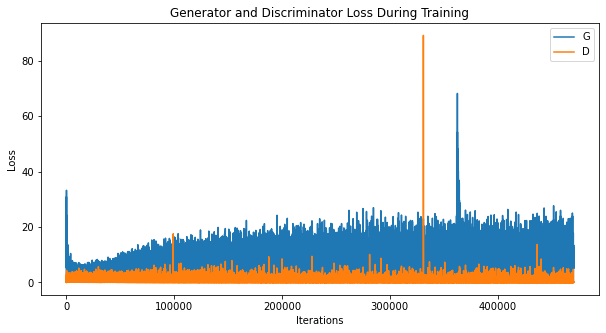

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

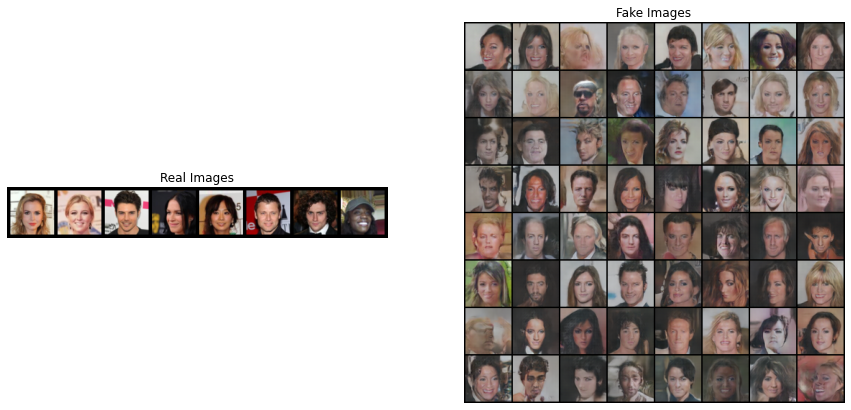

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [1]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_jshtml())

NameError: name 'plt' is not defined